In [48]:
import os
import sys
import numpy as np
import string
import pickle
import xarray as xr
import cartopy
import cmocean
import datetime
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
matplotlib.rc_file('../rc_file_paper')
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
sys.path.append("..")
from PIL import Image
from maps import rect_polygon
from tqdm import notebook
from paths import path_samoc, path_results, path_prace
from paths import file_ex_ocn_ctrl, file_ex_ocn_lc1, file_RMASK_ocn, file_RMASK_ocn_low
from regions import SST_index_bounds
from filters import lowpass
from constants import spy, A_earth
from scipy.stats import binned_statistic
from xr_regression import xr_quadtrend
from arch.bootstrap import StationaryBootstrap, optimal_block_length
from matplotlib.ticker import NullFormatter
from bb_analysis_timeseries import AnalyzeTimeSeries as ATS

The file "/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/run/spinup_pd_maxcores_f09_g16.cam2.h0.0001-01.nc" does not exist


color conventions:
- global black
- Atlantic blue
- Pacific orange
- Southern red

In [4]:
spy = 365*24*3600

# Fig 1 alternative: global SHF + TOA

In [5]:
# surface heat flux into the ocean; from SHF.ipynb
# SHF_ctrl = xr.open_dataset(f'{path_prace}/OHC/SHF_ctrl.nc', decode_times=False)  # [J/yr]
# SHF_lc1  = xr.open_dataset(f'{path_prace}/OHC/SHF_lc1.nc' , decode_times=False)
SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False)  # [W]
SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


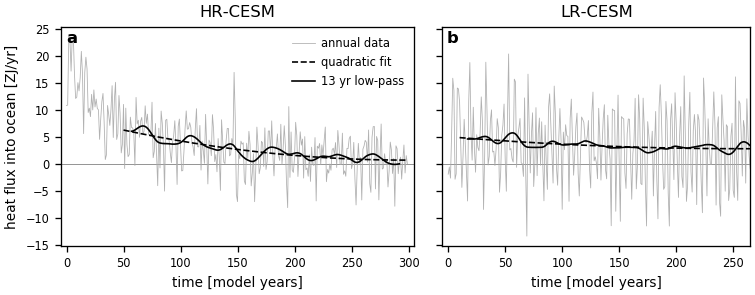

In [6]:
f, ax = plt.subplots(1, 2, sharey='row', gridspec_kw={'width_ratios':[31,27]}, figsize=(6.4, 2.5), constrained_layout=True)
for i, run in enumerate(['ctrl', 'lc1']):
    t1 = [50,10][i]
    da_SHF = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']
    ax[i].axhline(0, c='grey', lw=.5)
    ax[i].plot(da_SHF.time, da_SHF*spy/1e21, c='darkgrey', lw=.5, alpha=.9, label='annual data')

    ax[i].plot(da_SHF.time[t1:], xr_quadtrend(da_SHF[t1:])*spy/1e21, c='k', ls='--', label='quadratic fit')
    ax[i].plot(da_SHF.time[t1+7:-7], lowpass(da_SHF[t1:],13)[7:-7]*spy/1e21, c='k', label='13 yr low-pass')
    ax[i].title.set_text(['HR-CESM', 'LR-CESM'][i])
    ax[i].set_xlabel('time [model years]')
    ax[i].set_xlim((-5,[305,265][i]))
    ax[i].text(.015,.98, ['a','b'][i], transform=ax[i].transAxes, va='top', ha='left', weight='bold')
ax[0].legend(loc=1, fontsize=7, handlelength=2, handletextpad=0.5, frameon=False)
ax[0].set_ylabel(f'heat flux into ocean [ZJ/yr]')
# plt.savefig(f'{path_results}/MV-paper/SHF_ctrl_lc1')
plt.savefig(f'{path_results}/MV-paper/Fig1.eps')

# Figure 2: indices

cobe   AMO:  0.118
cobe   PDO:  0.087
cobe   SOM:  0.153
ersst  AMO:  0.138
ersst  PDO:  0.088
ersst  SOM:  0.192
had    AMV:  0.108
had    PDO:  0.085
had    SOM:  0.134
ctrl   AMV:  0.049
ctrl   PDO:  0.066
ctrl   SOM:  0.108


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


lc1    AMV:  0.032
lc1    PDO:  0.069
lc1    SOM:  0.067


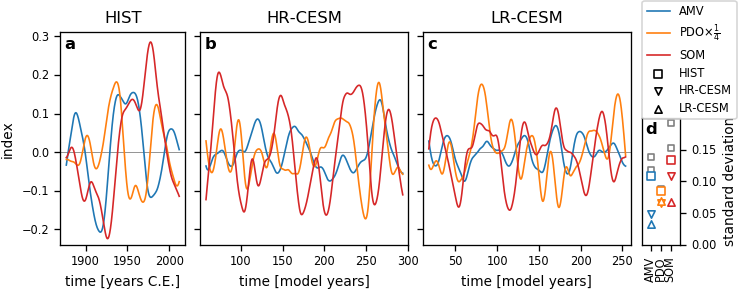

In [142]:
dc = {'decode_times':False}
f = plt.figure(figsize=(6.4, 2.5))
ax_std = f.add_axes([.85,.17,.05,.43])
ax_std.yaxis.tick_right()
ax_std.yaxis.set_label_position("right")
ax_std.set_yticks(np.arange(0,.2,.05))

    

for i, run in enumerate(['had', 'ctrl', 'lc1']):
    ax = f.add_axes([[.08,.265,.56][i], .17, [3,5,5][i]*0.055,.72])
    ax.axhline(0, c='grey', lw=.5)
    ax.title.set_text(['HIST', 'HR-CESM', 'LR-CESM'][i])
    if run=='ctrl':   ts, times = '_51_301' , np.arange(  51, 301,1/12)+1/12
    elif run=='lc1':  ts, times = '_11_261' , np.arange(  11, 261,1/12)+1/12
    elif run=='had':
        ts, times = ''        , np.arange(1870,2019,1/12)+1/12
        for k, run_ in enumerate(['cobe','ersst']):   # alt. obs.
            ls = ['--',':'][k]
            AMO = xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_{run_}.nc', **dc)
            PDO = xr.open_dataset(f'{path_prace}/SST/PMV_EOF_20N_{run_}.nc', **dc).pcs.isel(mode=0).squeeze()
            SOM = xr.open_dataarray(f'{path_prace}/SST/SOM_ds_dt_raw_{run_}.nc', **dc)
#             ax.plot(times[7*12:-7*12], lowpass(AMO,12*13)[7*12:-7*12]  , c='C0', lw=.5, ls=ls)
#             ax.plot(times[7*12:-7*12], lowpass(PDO,12*13)[7*12:-7*12]/4, c='C1', lw=.5, ls=ls)
#             ax.plot(times[7*12:-7*12], lowpass(SOM,12*13)[7*12:-7*12]  , c='C3', lw=.5, ls=ls)
            for l, da in enumerate([AMO,PDO,SOM]):
                std = lowpass(da, 12*13)[7*12:-7*12].std().values/[1,4,1][l]
                ax_std.scatter(l, std, facecolor='w', edgecolor='grey', marker=['s','v','^'][i], s=15)
                print(f'{run_:6} {["AMO","PDO","SOM"][l]}:  {std:.3f}')
    
    for j, idx in enumerate(['AMV', 'PDO', 'SOM']):
        c = ['C0', 'C1','C3'][j]
        if idx=='AMV':
            da = xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_{run}{ts}.nc', **dc)
        elif idx=='SOM':
            da = xr.open_dataarray(f'{path_prace}/SST/SOM_ds_dt_raw_{run}{ts}.nc', **dc)
        elif idx=='PDO':
            fn = f'{path_prace}/SST/PMV_EOF_20N_{run}{ts}.nc'
            da = xr.open_dataset(fn, **dc).pcs.isel(mode=0).squeeze()
            
        ax.plot(da.time[7*12:-7*12]/[365,1,365,365][i]+[1870,0,0,0][i],
                lowpass(da, 12*13)[7*12:-7*12]*[1,1/4,1][j], c=c)
        print(f'{run:6} {idx}:  {lowpass(da, 12*13)[7*12:-7*12].std().values*[1,1/4,1][j]:.3f}')
        ax_std.scatter(j, lowpass(da, 12*13)[7*12:-7*12].std().values/[1,4,1][j],
                       facecolor='w', edgecolor=c, marker=['s','v','^'][i], s=20)
        
    ax.set_xlabel(f'time [{["years C.E.", "model years", "model years"][i]}]')
    ax.set_ylim((-.24,.31))
    ax.set_xlim([(1870,2019), (51,300), (11,260)][i])
    ax.text([.03,.02,.02][i],.98, ['a','b', 'c'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')
    if i==0:  
        ax.set_ylabel(f'index')
        ax_ = ax
    else:    
        plt.setp(ax.get_yticklabels(), visible=False)
#         ax.set_
ax_std.text(.1,.97, 'd', transform=ax_std.transAxes, va='top', ha='left', weight='bold')
ax_std.set_xticks([0,1,2])
ax_std.set_xticklabels(['AMV','PDO','SOM'], rotation=90)
ax_std.set_ylabel('standard deviation')
h1, h2 = [], []
for i, idx in enumerate(['AMV', 'PDO', 'SOM']):
    l, = ax_std.plot([],[],c=['C0', 'C1','C3'][i], label=idx+['', r'$\times\frac{1}{4}$',''][i])
    s = ax_std.scatter(5, 0, facecolor='w', edgecolor='k', marker=['s','v','^'][i], s=20, label=['HIST','HR-CESM','LR-CESM'][i])
    h1.append(l)
    h2.append(s)
l1 = ax_std.legend(handles=h1+h2, fontsize=7, labelspacing=.4, bbox_to_anchor=(-.14, 1.97), loc='upper left')
# l2 = ax_std.legend(handles=h2, fontsize=7, bbox_to_anchor=(0, 1.3), loc='upper left')
# ax_std.add_artist(l1)
ax_std.set_xlim((-.9,2.9))
ax_std.set_ylim((0,.2))

# ax = f.add_axes()
# plt.savefig(f'{path_results}/MV-paper/indices_ctrl_lc1')
# plt.savefig(f'{path_results}/MV-paper/Fig2.eps') # old version

cobe   AMO:  0.115
cobe   PDO:  0.335
cobe   SOM:  0.146
ersst  AMO:  0.128
ersst  PDO:  0.340
ersst  SOM:  0.186


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


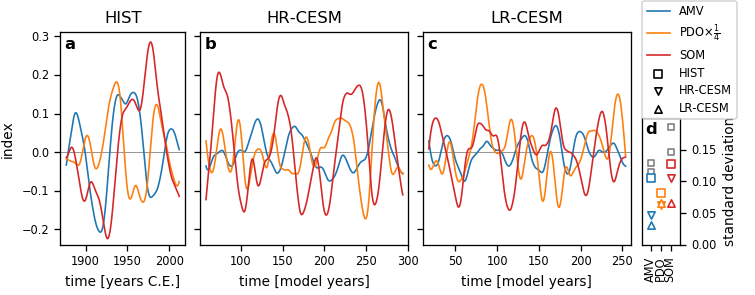

In [146]:
f = plt.figure(figsize=(6.4, 2.5))
ax_std = f.add_axes([.85,.17,.05,.43])
ax_std.yaxis.tick_right()
ax_std.yaxis.set_label_position("right")
ax_std.set_yticks(np.arange(0,.2,.05))
for i, run in enumerate(['had', 'ctrl', 'lc1']):
    ax = f.add_axes([[.08,.265,.56][i], .17, [3,5,5][i]*0.055,.72])
    ax.axhline(0, c='grey', lw=.5)
    ax.title.set_text(['HIST', 'HR-CESM', 'LR-CESM'][i])
    if run=='ctrl':   ts, times = '_51_301' , np.arange(  51, 301,1/12)+1/12
    elif run=='lc1':  ts, times = '_11_261' , np.arange(  11, 261,1/12)+1/12
    elif run=='had':
        ts, times = ''        , np.arange(1870,2019,1/12)+1/12
        for k, run_ in enumerate(['cobe','ersst']):   # alt. obs.
            ls = ['--',':'][k]
            AMO = xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_{run_}.nc', **dc)
            PDO = xr.open_dataset(f'{path_prace}/SST/PMV_EOF_20N_{run_}.nc', **dc).pcs.isel(mode=0).squeeze()
            SOM = xr.open_dataarray(f'{path_prace}/SST/SOM_ds_dt_raw_{run_}.nc', **dc)
#             ax.plot(times[7*12:-7*12], lowpass(AMO,12*13)[7*12:-7*12]  , c='C0', lw=.5, ls=ls)
#             ax.plot(times[7*12:-7*12], lowpass(PDO,12*13)[7*12:-7*12]/4, c='C1', lw=.5, ls=ls)
#             ax.plot(times[7*12:-7*12], lowpass(SOM,12*13)[7*12:-7*12]  , c='C3', lw=.5, ls=ls)
            for l, da in enumerate([AMO,PDO,SOM]):
                da_ = lowpass(da, 12*13)[7*12:-7*12]
                n = int(optimal_block_length(da_.values)['stationary'].values)
                bs = StationaryBootstrap(n, da_.values)
                da_std = bs.apply(np.std, 100).mean()
                ax_std.scatter(l, da_std/[1,4,1][j],
                               facecolor='w', edgecolor='grey', marker=['s','v','^'][i], s=15)
                print(f'{run_:6} {["AMO","PDO","SOM"][l]}:  {da_std/[1,4,1][j]:.3f}')
    
    for j, idx in enumerate(['AMV', 'PDO', 'SOM']):
        c = ['C0', 'C1','C3'][j]
        if idx in ['AMV', 'SOM']:
            if idx=='AMV':    fn = f'{path_prace}/SST/AMO_ds_dt_raw_{run}{ts}.nc'
            elif idx=='SOM':  fn = f'{path_prace}/SST/{idx}_ds_dt_raw_{run}{ts}.nc'
            da = xr.open_dataarray(fn, decode_times=False)
        elif idx=='PDO':
            fn = f'{path_prace}/SST/PMV_EOF_20N_{run}{ts}.nc'
            da = xr.open_dataset(fn, decode_times=False).pcs.isel(mode=0).squeeze()
        ax.plot(da.time[7*12:-7*12]/[365,1,365,365][i]+[1870,0,0,0][i],
                   lowpass(da, 12*13)[7*12:-7*12]*[1,1/4,1][j], c=c)
        
        da_ = lowpass(da, 12*13)[7*12:-7*12]
        n = int(optimal_block_length(da_.values)['stationary'].values)
        bs = StationaryBootstrap(n, da_.values)
        da_std = bs.apply(np.std, 100).mean()
        ax_std.scatter(j, da_std/[1,4,1][j],
                       facecolor='w', edgecolor=c, marker=['s','v','^'][i], s=20)
    ax.set_xlabel(f'time [{["years C.E.", "model years", "model years"][i]}]')
    ax.set_ylim((-.24,.31))
    ax.set_xlim([(1870,2019), (51,300), (11,260)][i])
    ax.text([.03,.02,.02][i],.98, ['a','b', 'c'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')
    if i==0:  
        ax.set_ylabel(f'index')
        ax_ = ax
    else:    
        plt.setp(ax.get_yticklabels(), visible=False)

ax_std.text(.1,.97, 'd', transform=ax_std.transAxes, va='top', ha='left', weight='bold')
ax_std.set_xticks([0,1,2])
ax_std.set_xticklabels(['AMV','PDO','SOM'], rotation=90)
ax_std.set_ylim((0,.2))
ax_std.set_ylabel('standard deviation')
h1, h2 = [], []
for i, idx in enumerate(['AMV', 'PDO', 'SOM']):
    l, = ax_std.plot([],[],c=['C0', 'C1','C3'][i], label=idx+['', r'$\times\frac{1}{4}$',''][i])
    s = ax_std.scatter(5, 0, facecolor='w', edgecolor='k', marker=['s','v','^'][i], s=20, label=['HIST','HR-CESM','LR-CESM'][i])
    h1.append(l)
    h2.append(s)
l1 = ax_std.legend(handles=h1+h2, fontsize=7, labelspacing=.4, bbox_to_anchor=(-.14, 1.97), loc='upper left')
ax_std.set_xlim((-.9,2.9))
plt.savefig(f'{path_results}/MV-paper/Fig2.eps')

In [8]:
from filters import bandpass

had  AMV:  0.112
ctrl AMV:  0.043
lc1  AMV:  0.043
had  PDO:  0.385
ctrl PDO:  0.358
lc1  PDO:  0.316
had  SOM:  0.073
ctrl SOM:  0.117
lc1  SOM:  0.083


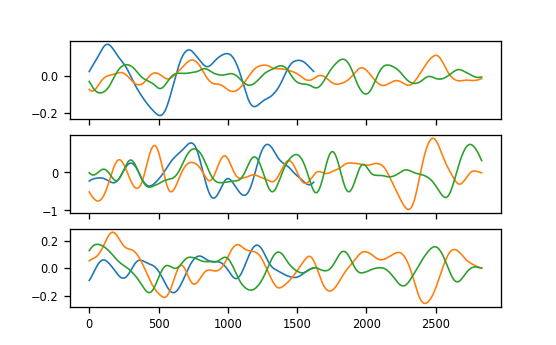

In [9]:
f, ax = plt.subplots(3,1, sharex=True)
for j, idx in enumerate(['AMV', 'PDO', 'SOM']):
    for i, run in enumerate(['had', 'ctrl', 'lc1']):
        if run=='ctrl':   ts, times = '_51_301' , np.arange(  51, 301,1/12)+1/12
        elif run=='lc1':  ts, times = '_11_261' , np.arange(  11, 261,1/12)+1/12
        elif run=='had':  ts, times = ''        , np.arange(1870,2019,1/12)+1/12
        c = ['C0', 'C1','C3'][j]
        if idx in ['AMV', 'SOM']:
            if idx=='AMV':    fn = f'{path_prace}/SST/AMO_ds_dt_raw_{run}{ts}.nc'
            elif idx=='SOM':  fn = f'{path_prace}/SST/{idx}_ds_dt_raw_{run}{ts}.nc'
            da = xr.open_dataarray(fn, decode_times=False)
        elif idx=='PDO':
            fn = f'{path_prace}/SST/PMV_EOF_20N_{run}{ts}.nc'
            da = xr.open_dataset(fn, decode_times=False).pcs.isel(mode=0).squeeze()
        print(f'{run:4} {idx}:  {bandpass(da, 12*10, 12*50)[7*12:-7*12].std().values:.3f}')
        ax[j].plot(bandpass(da, 12*10, 12*50)[7*12:-7*12])

# Fig 3: SST index regression patterns
from `OHC-ctrl_vs_lpd.ipynb`

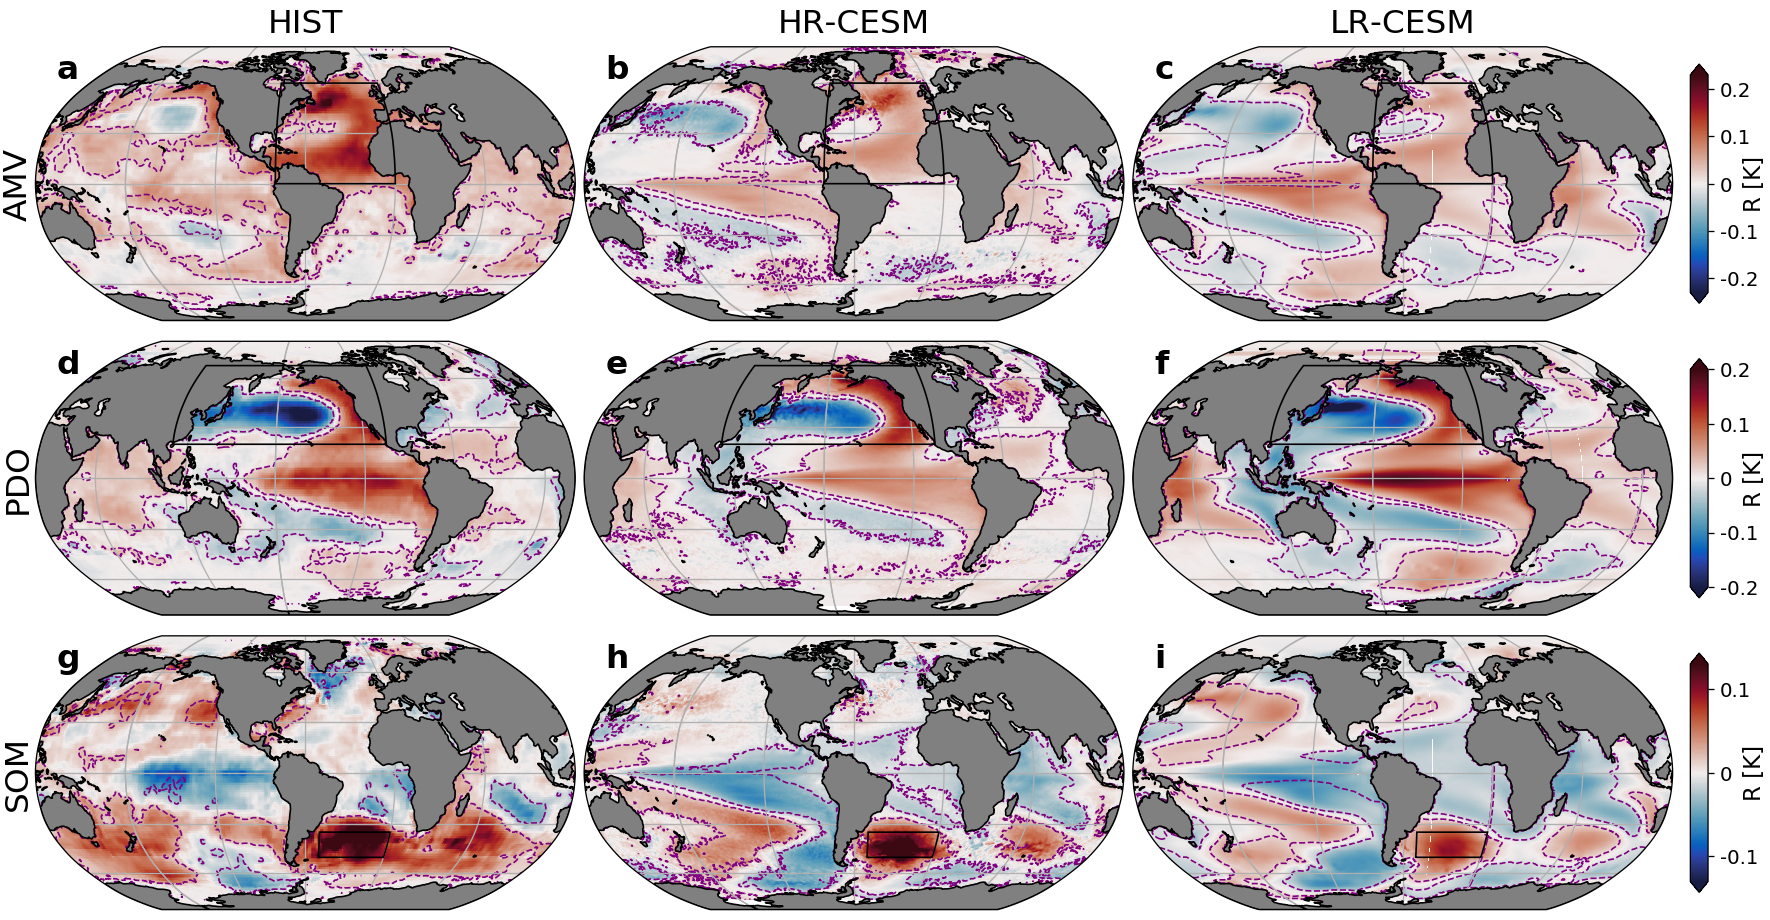

In [10]:
f = plt.figure(figsize=(15,7.8), constrained_layout=False)

for i, idx in enumerate(['AMO', 'PMV_EOF_20N', 'SOM']):
#     maxv = [.4, .3, .25][i]
#     maxv = [3, 2, 1.5][i]
    maxv = [.23, .2, .13][i]
    ticks = [-.3,-.2,-.1,0,.1,.2,.3]
    ax = f.add_subplot(3, 5, 1+i*5)
    ax.set_position([.009,.01+(2-i)*.32,.02,.3])
    ax.text(.5, .5, ['AMV', 'PDO', 'SOM'][i], transform=ax.transAxes, rotation='vertical', va='center', ha='right', fontsize=20)
    ax.axis('off')
    
    rects = [[rect_polygon(SST_index_bounds('AMO'))], 
             [rect_polygon(SST_index_bounds('PDO'))],
             [rect_polygon(SST_index_bounds('SOM'))]
            ][i]
    
    for j, run in notebook.tqdm(enumerate(['had', 'ctrl', 'lc1'])):
        if run=='had':  ts = ''
        if run=='ctrl':  ts = '_51_301' 
        if run=='lc1':  ts = '_11_261'
        if idx in ['AMO', 'TPI', 'SOM']:
            std = lowpass(xr.open_dataarray(f'{path_prace}/SST/{idx}_ds_dt_raw_{run}{ts}.nc'), 12*13).std().values
            xa = xr.open_dataset(f'{path_prace}/SST/{idx}_regr_{run}{ts}.nc')
        else:
            std = lowpass(xr.open_dataset(f'{path_prace}/SST/{idx}_{run}{ts}.nc').pcs.isel(mode=0), 12*13).std().values
            xa = xr.open_dataset(f'{path_prace}/SST/PMV_20N_regr_{run}{ts}.nc')
            
        if run=='had':
            lats, lons = xa.latitude, xa.longitude; lons, lats = np.meshgrid(lons, lats)
        elif run=='ctrl':
            lats, lons = xa.t_lat, xa.t_lon; lons, lats = np.meshgrid(lons, lats)
        elif run=='lc1':
            lats = xr.open_dataset(file_ex_ocn_lc1).TLAT.values
            lons = xr.open_dataset(file_ex_ocn_lc1).TLONG.values
        
        ax = f.add_subplot(3, 5, j+2+i*5, projection=ccrs.Robinson(central_longitude=[-60, 200, -60][i]))
        if i==0:  ax.text(.5, 1.05, ['HIST', 'HR-CESM', 'LR-CESM'][j], transform=ax.transAxes, fontsize=20, ha='center')
        ax.set_global()
        ax.set_position([.02+j*.31,.01+(2-i)*.32,.305,.3])

        im = ax.pcolormesh(lons, lats, xa.slope*std, cmap='cmo.balance',
                           vmin=-maxv, vmax=maxv, transform=ccrs.PlateCarree())
        plt.tricontour(lons.flatten(), lats.flatten(), xa.pval.where(np.isnan(xa.pval.values)==False, .5).values.flatten(),
                       levels=[.01,.99], colors='purple', linestyles='dashed', transform=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
        gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        
        for rect in rects:
            ax.add_patch(matplotlib.patches.Polygon(xy=rect,
                                          facecolor='none', edgecolor='k',
                                          linewidth=1, zorder=3,
                                          transform=ccrs.PlateCarree(), ), )
        ax.text(0.04,.97, string.ascii_lowercase[3*i+j], transform=ax.transAxes, va='top', ha='left', weight='bold', fontsize=20)        
    ax = f.add_subplot(3, 5, 5+i*5)
    ax.set_position([.955,.03+(2-i)*.32,.01,.26])
    cbar = plt.colorbar(im, cax=ax, shrink=.9, pad=.0, orientation='vertical', extend='both', ticks=ticks)
    cbar.ax.set_yticklabels(ticks, fontsize=12)
    f.text(.985,.16+(2-i)*.32, 'R [K]', fontsize=14, va='center', rotation=90)
# plt.savefig(f'{path_results}/MV-paper/regression_patterns_AMV_PMV_SOM')
plt.savefig(f'{path_results}/MV-paper/Fig3.tif')
plt.savefig(f'{path_results}/MV-paper/Fig3.png')


# Fig 4: SST index spectra
data from `SST_indices.ipynb`; multitaper spectra of raw SST indices (i.e. not filtered)

In [56]:
def band_integral(spec, monthly=True):
    """ integrates between 10 and 50 years periods
    input:
    spec  .. tuple with spectrum, frequency
    output:
    p  .. power in [10,50] year range
    rp .. relative power [10,50]/[1,10]
    """
    if monthly: f = 12
    else:       f = 1
    lf_band = np.logical_and(spec[1]*f>1/50 , spec[1]*f<=1/10)
    hf_band = np.logical_and(spec[1]*f>1/10 , spec[1]*f<=1/2)
    fi_band = np.logical_and(spec[1]*f>1/150, spec[1]*f<=1/10) # similar to 13 year lowpass filter
    df = spec[1][1] - spec[1][0]    
    lf_power = df*np.sum(lf_band*spec[0])
    hf_power = df*np.sum(hf_band*spec[0])
    fi_power = df*np.sum(fi_band*spec[0])
    to_power = df*np.sum(spec[0])
    
    edges = np.logspace(np.log10(1/50),np.log10(1/2),num=17)
    bs = binned_statistic(spec[1]*f,spec[0]/f, bins=edges)
    mv_mean, iv_mean = np.mean(np.split(bs[0], 2), axis=1)
#     mv_mean, iv_mean = np.median(np.split(bs[0], 2), axis=1)
    
    centers = np.logspace(np.log10(1/50),np.log10(1/2),num=33)[1::2]
    x, _ = np.split(centers, 2)
    y, _ = np.split(bs[0], 2)
    slope, intercept = np.polyfit(np.log10(x), np.log10(y), deg=1)
    mv_exp, mv_factor = slope, 10**intercept  # plot as plt.plot(edges[:9], mv_factor*(x)**mv_exp); x=edges[:9]
    return to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor

""" alternative measures based on log(f)-weights"""

def mean_power(A):
    std = 10**((np.log10(A[2][:,1]/12)-np.log10(A[2][:,0]/12))/4)
    f_MV = (A[1]*12>1/50)*(A[1]*12<=1/10)
    f_IV = (A[1]*12>1/10)*(A[1]*12<=1/2 )
    w_MV = np.log(A[1][1:])*f_MV[1:]
    w_IV = np.log(A[1][1:])*f_IV[1:]
    mu_MV = np.average(A[0][1:]/12, weights=w_MV)
    mu_IV = np.average(A[0][1:]/12, weights=w_IV)
    sd_MV = np.sqrt( np.sum(w_MV*np.log10(std[1:])**2*f_MV[1:]) / np.sum(w_MV))# * (np.sum(f_MV))/(np.sum(f_MV)-1) )
    sd_IV = np.sqrt( np.sum(w_IV*np.log10(std[1:])**2*f_IV[1:]) / np.sum(w_IV))# * (np.sum(f_IV))/(np.sum(f_IV)-1) )
    return std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV

def calc_slope(A):
    f_MV = (A[1]*12>1/50)*(A[1]*12<=1/10)
    x = np.delete(A[1]*12, np.where(f_MV==False))
    y = np.delete(A[0]/12, np.where(f_MV==False))

    weights = -np.log(x)
    X = sm.add_constant(np.log10(x))
    wm = sm.WLS(np.log10(y), X, weights=weights)
    r = wm.fit()
    offset = r.params[0]
    slope = r.params[1]
    slope_SE = r.bse[1]
    return offset, slope, slope_SE

In [147]:
# calculate spectra and put them into dictionary
fn_dict = f'{path_results}/MV-paper/idx_spectra.pkl'
if os.path.exists(fn_dict):
# if os.path.exists(fn_dict)==False:  # to force creation
    spec_dict_unfilt = pickle.load(open(fn_dict, 'rb'))
else:
    spec_dict_unfilt = {}
    ft = 'lowpass'
    for i, run in enumerate(['had', 'ctrl', 'lc1', 'cobe', 'ersst']):
        if run=='ctrl':   ts = '_51_301' 
        elif run=='lc1':  ts = '_11_261' 
        elif run in ['had', 'cobe', 'ersst']:  ts = ''
        for j, idx in notebook.tqdm(enumerate(['AMO', 'SOM', 'TPI', 'PMV_EOF_20N', 'PMV_EOF_Eq', 'PMV_EOF_38S'])):
            if idx in ['AMO','SOM','TPI']: dt = '_ds_dt_raw'
            else:                          dt = ''
            if run in ['cobe', 'ersst'] and idx in ['TPI', 'PMV_EOF_Eq', 'PMV_EOF_38S']:  continue
            fc = 12*13
            fn = f'{path_prace}/SST/{idx}{dt}_{run}{ts}.nc'
            assert os.path.exists(fn), f'{fn} does not exist'
            if idx in ['AMO', 'SOM', 'TPI']:  da = xr.open_dataarray(fn, decode_times=False)
            else:                             da = xr.open_dataset(fn, decode_times=False).pcs.isel(mode=0).squeeze()
            da = da.isel(time=slice(0,int(250*12)))
    #         assert len(da) in [12*149, 12*150, 12*250]
            spec_dict_unfilt[f'{idx}_{run}_spec'] = ATS(da).spectrum()
            spec_dict_unfilt[f'{idx}_{run}_rnnh'] = ATS(da).mc_ar1_spectrum(N=10000)  # red noise spectrum
    pickle.dump(spec_dict_unfilt, open(fn_dict, 'wb'))
spec_dict_unfilt.keys()

dict_keys(['AMO_had_spec', 'AMO_had_rnnh', 'SOM_had_spec', 'SOM_had_rnnh', 'TPI_had_spec', 'TPI_had_rnnh', 'PMV_EOF_20N_had_spec', 'PMV_EOF_20N_had_rnnh', 'PMV_EOF_Eq_had_spec', 'PMV_EOF_Eq_had_rnnh', 'PMV_EOF_38S_had_spec', 'PMV_EOF_38S_had_rnnh', 'AMO_ctrl_spec', 'AMO_ctrl_rnnh', 'SOM_ctrl_spec', 'SOM_ctrl_rnnh', 'TPI_ctrl_spec', 'TPI_ctrl_rnnh', 'PMV_EOF_20N_ctrl_spec', 'PMV_EOF_20N_ctrl_rnnh', 'PMV_EOF_Eq_ctrl_spec', 'PMV_EOF_Eq_ctrl_rnnh', 'PMV_EOF_38S_ctrl_spec', 'PMV_EOF_38S_ctrl_rnnh', 'AMO_lc1_spec', 'AMO_lc1_rnnh', 'SOM_lc1_spec', 'SOM_lc1_rnnh', 'TPI_lc1_spec', 'TPI_lc1_rnnh', 'PMV_EOF_20N_lc1_spec', 'PMV_EOF_20N_lc1_rnnh', 'PMV_EOF_Eq_lc1_spec', 'PMV_EOF_Eq_lc1_rnnh', 'PMV_EOF_38S_lc1_spec', 'PMV_EOF_38S_lc1_rnnh', 'AMO_cobe_spec', 'AMO_cobe_rnnh', 'SOM_cobe_spec', 'SOM_cobe_rnnh', 'PMV_EOF_20N_cobe_spec', 'PMV_EOF_20N_cobe_rnnh', 'AMO_ersst_spec', 'AMO_ersst_rnnh', 'SOM_ersst_spec', 'SOM_ersst_rnnh', 'PMV_EOF_20N_ersst_spec', 'PMV_EOF_20N_ersst_rnnh'])

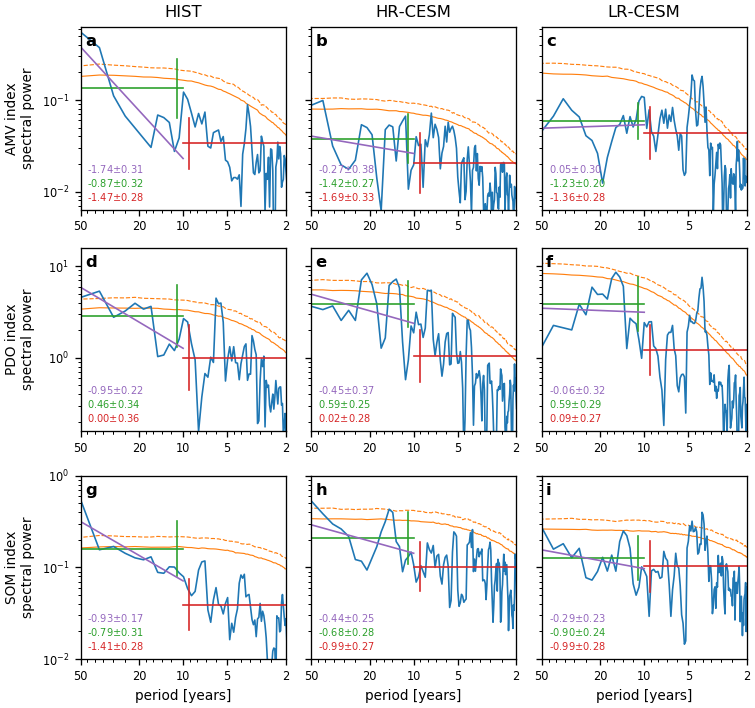

In [143]:
# spectra
xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
f, ax = plt.subplots(3, 3, figsize=(6.4,6), sharey='row', constrained_layout=True)
for i, run in enumerate(['had', 'ctrl', 'lc1']):
    for j, idx in enumerate(['AMO', 'PMV_EOF_20N', 'SOM']):
        factor = 12
        spec = spec_dict_unfilt[f'{idx}_{run}_spec']
        rnnh = spec_dict_unfilt[f'{idx}_{run}_rnnh']
        
        offset, slope, slope_SE = calc_slope(spec)
        std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power(spec)
        
        ax[j,i].set_xscale('log', basex=10)
        ax[j,i].set_yscale('log', basey=10)
        ax[j,i].set_xlim((1/50,1/2))
        power = [-0.2,1.2,0][j]
        ax[j,i].set_ylim(top=10**(power), bottom=10**(power-2))
        # l50, = ax[j,i].plot(rnnh['freq']*factor, rnnh['median']/factor, c='C1', label='AR(1) 50%')
        l95, = ax[j,i].plot(rnnh['freq']*factor, rnnh['95']/factor, c='C1', ls='-' , lw=.7, label='AR(1) 95%')
        l99, = ax[j,i].plot(rnnh['freq']*factor, rnnh['99']/factor, c='C1', ls='--', lw=.7, label='AR(1) 99%')
        lmt, = ax[j,i].plot(spec[1]     *factor, spec[0]   /factor, c='C0', label='MTM spectrum')
        ax[j,0].set_ylabel(f'{["AMV", "PDO", "SOM"][j]} index\nspectral power')
        ax[j,i].xaxis.set_minor_locator(locmin)
        ax[j,i].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax[j,i].set_xticks([1/x for x in xticks])
        ax[j,i].set_xticklabels(xticks)
        ax[j,i].text(.02,.96, string.ascii_lowercase[3*j+i], transform=ax[j,i].transAxes, va='top', ha='left', weight='bold')
        
        ax[j,i].plot([1/50,1/10], 2*[mu_MV], c='C2', ls='-')
        ax[j,i].plot([1/10,1/2 ], 2*[mu_IV], c='C3', ls='-')
        ax[j,i].plot(2*[1/10/1.1], [mu_MV*10**sd_MV, mu_MV/10**sd_MV], c='C2', ls='-')
        ax[j,i].plot(2*[1/10*1.1], [mu_IV*10**sd_IV, mu_IV/10**sd_IV], c='C3', ls='-')
        
        edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
        slope_, = ax[j,i].plot(edges, 10**offset*edges**slope, ls='-', c='C4')
        ax[j,i].text(1/45, 10**(power-1.6 ), f'{slope:.2f}$\pm${slope_SE:.2f}'            , color='C4', fontsize=6)
        ax[j,i].text(1/45, 10**(power-1.75), f'{np.log10(mu_MV):.2f}$\pm${sd_MV:.2f}', color='C2', fontsize=6)
        ax[j,i].text(1/45, 10**(power-1.9 ), f'{np.log10(mu_IV):.2f}$\pm${sd_IV:.2f}', color='C3', fontsize=6)
    ax[0,i].title.set_text(['HIST', 'HR-CESM', 'LR-CESM'][i])
    ax[-1,i].set_xlabel('period [years]')
f.align_ylabels()
plt.savefig(f'{path_results}/MV-paper/Fig4_main.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


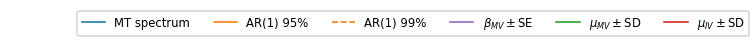

In [141]:
f = plt.figure(figsize=(6.4,.4))
ax = f.add_axes([0,0,1,1])
plt.plot([],[], c='C0', ls='-', label='MT spectrum')
plt.plot([],[], c='C1', ls='-', label='AR(1) 95%')
plt.plot([],[], c='C1', ls='--', label='AR(1) 99%')
plt.plot([],[], c='C4', ls='-', label=r'$\beta_{MV} \pm\!\!$ SE')
plt.plot([],[], c='C2', ls='-', label=r'$\mu_{MV} \pm\!\!$ SD')
plt.plot([],[], c='C3', ls='-', label=r'$\mu_{IV} \pm\!\!$ SD')
plt.legend(ncol=6, fontsize=7.1, loc='right')
plt.axis('off')
plt.savefig(f'{path_results}/MV-paper/Fig4_legend.eps')

In [ ]:
im2 = Image.open('../../results/MV-paper/Fig4_main.eps')
im1 = Image.open('../../results/MV-paper/Fig4_legend.eps')

im = Image.new('RGB', (im1.width, im1.height + im2.height))
im.paste(im1, (0, 0))
im.paste(im2, (0, im1.height))

im.save('../../results/MV-paper/Fig4.eps')
im

### Appendix Fig. A1: HadISST, COBE, and ERSST -- time series, spectra, maybe patterns

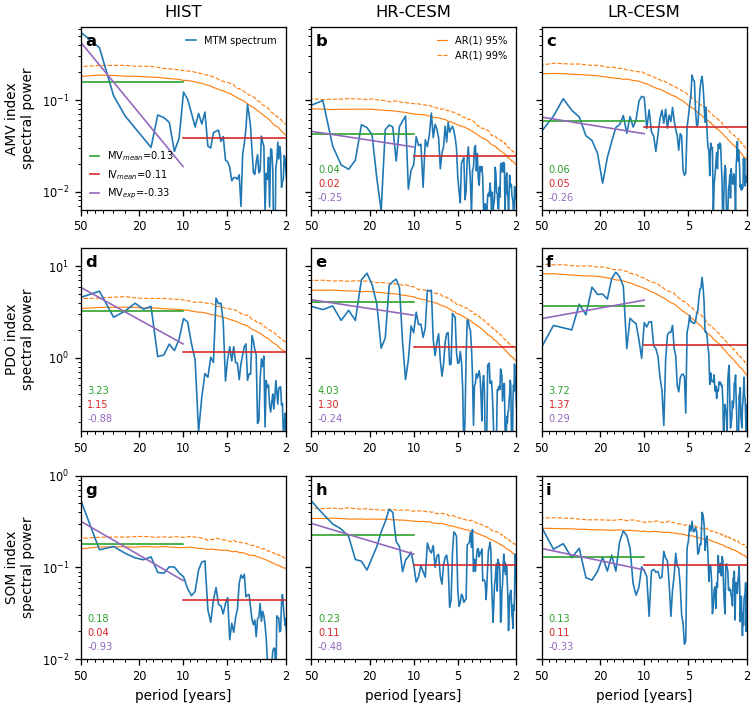

In [83]:
# spectra
xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
f, ax = plt.subplots(3, 3, figsize=(6.4,6), sharey='row', constrained_layout=True)
for i, run in enumerate(['had', 'ctrl', 'lc1']):
    for j, idx in enumerate(['AMO', 'PMV_EOF_20N', 'SOM']):
        factor = 12
        spec = spec_dict_unfilt[f'{idx}_{run}_spec']
        rnnh = spec_dict_unfilt[f'{idx}_{run}_rnnh']
        
        offset, slope, slope_SE = calc_slope(spec)
        std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power(spec)
        
        ax[j,i].set_xscale('log', basex=10)
        ax[j,i].set_yscale('log', basey=10)
        ax[j,i].set_xlim((1/50,1/2))
        power = [-0.2,1.2,0][j]
        ax[j,i].set_ylim(top=10**(power), bottom=10**(power-2))
        # l50, = ax[j,i].plot(rnnh['freq']*factor, rnnh['median']/factor, c='C1', label='AR(1) 50%')
        l95, = ax[j,i].plot(rnnh['freq']*factor, rnnh['95']/factor, c='C1', ls='-' , lw=.7, label='AR(1) 95%')
        l99, = ax[j,i].plot(rnnh['freq']*factor, rnnh['99']/factor, c='C1', ls='--', lw=.7, label='AR(1) 99%')
        lmt, = ax[j,i].plot(spec[1]     *factor, spec[0]   /factor, c='C0', label='MTM spectrum')
        ax[j,0].set_ylabel(f'{["AMV", "PDO", "SOM"][j]} index\nspectral power')
        ax[j,i].xaxis.set_minor_locator(locmin)
        ax[j,i].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax[j,i].set_xticks([1/x for x in xticks])
        ax[j,i].set_xticklabels(xticks)
        ax[j,i].text(.02,.96, string.ascii_lowercase[3*j+i], transform=ax[j,i].transAxes, va='top', ha='left', weight='bold')

        to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral(spec)
        mv, = ax[j,i].plot([1/50,1/10], 2*[mv_mean], c='C2', label=f'MV$_{{mean}}$={mv_mean:.2f}')
        iv, = ax[j,i].plot([1/10,1/2 ], 2*[iv_mean], c='C3', label=f'IV$_{{mean}}$={iv_mean:.2f}')
        
        ax[j,i].plot([1/50,1/10], 2*[mu_MV], c='C2', ls='--')
        ax[j,i].plot([1/10,1/2 ], 2*[mu_IV], c='C3', ls='--')
        ax[j,i].plot(2*[1/10/1.1], [mu_MV*10**sd_MV, mu_MV/10**sd_MV], c='C2', ls='--')
        ax[j,i].plot(2*[1/10*1.1], [mu_IV*10**sd_IV, mu_IV/10**sd_IV], c='C3', ls='--')
        
        edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
        ax[j,i].plot(edges, 10**offset*edges**slope, ls='-', c='C4')
#         slope, = ax[j,i].plot(edges, mv_factor*(edges)**mv_exp, c='C4', label=f'MV$_{{exp}}$={mv_exp:.2f}')
        if i!=0 or j!=0:
            ax[j,i].text(1/45, 10**(power-1.6), f'{mv_mean:.2f}', color='C2', fontsize=6)
            ax[j,i].text(1/45, 10**(power-1.75), f'{iv_mean:.2f}', color='C3', fontsize=6)
            ax[j,i].text(1/45, 10**(power-1.9), f'{mv_exp:.2f}' , color='C4', fontsize=6)
    ax[0,i].title.set_text(['HIST', 'HR-CESM', 'LR-CESM'][i])
    ax[-1,i].set_xlabel('period [years]')
l0 = ax[0,0].legend(handles=[mv, iv, slope], loc=3, fontsize=6, frameon=False, handlelength=1)
l1 = ax[0,0].legend(handles=[lmt], loc=1, fontsize=6, frameon=False, handlelength=1)
l2 = ax[0,1].legend(handles=[l95, l99], loc=1, fontsize=6, frameon=False, handlelength=1)
ax[0,0].add_artist(l0)
f.align_ylabels()
# plt.savefig(f'{path_results}/MV-paper/index_mtm')
# plt.savefig(f'{path_results}/MV-paper/Fig4.eps')
plt.savefig(f'{path_results}/MV-paper/Fig4.eps')

# Fig. 5: SHF spectra

In [13]:
SHF_ctrl = xr.open_dataset(f'{path_prace}/OHC/SHF_ctrl.nc', decode_times=False).isel(time=slice(50,300))
SHF_lc1  = xr.open_dataset(f'{path_prace}/OHC/SHF_lc1.nc' , decode_times=False).isel(time=slice(10,260))

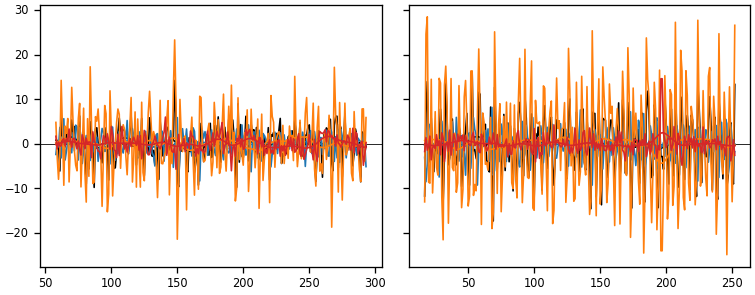

In [14]:
f, ax = plt.subplots(1,2,figsize=(6.4,2.5), sharey=True, constrained_layout=True)
# plt.gca().tick_params(labelsize=14)
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ax[i].axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21, 13)
        ax[i].plot(ts.time[7:-7]/365, ts_[7:-7], c=c)
        ax[i].plot(ts.time[7:-7]/365, ts__[7:-7], c=c)
# ax[1].set_xlim((190,210))

In [53]:
SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False).isel(time=slice(50,300))
SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False).isel(time=slice(10,260))

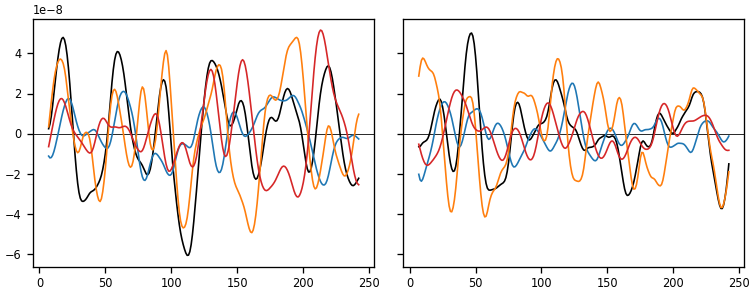

In [16]:
f, ax = plt.subplots(1,2,figsize=(6.4,2.5), sharey=True, constrained_layout=True)
# plt.gca().tick_params(labelsize=14)
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ax[i].axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21, 13)
        ax[i].plot(ts.time[7:-7], ts_[7:-7], c=c)
        # ax[i].plot(ts.time[7:-7]/365, ts__[7:-7], c=c)
# ax[1].set_xlim((190,210))

In [54]:
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The P

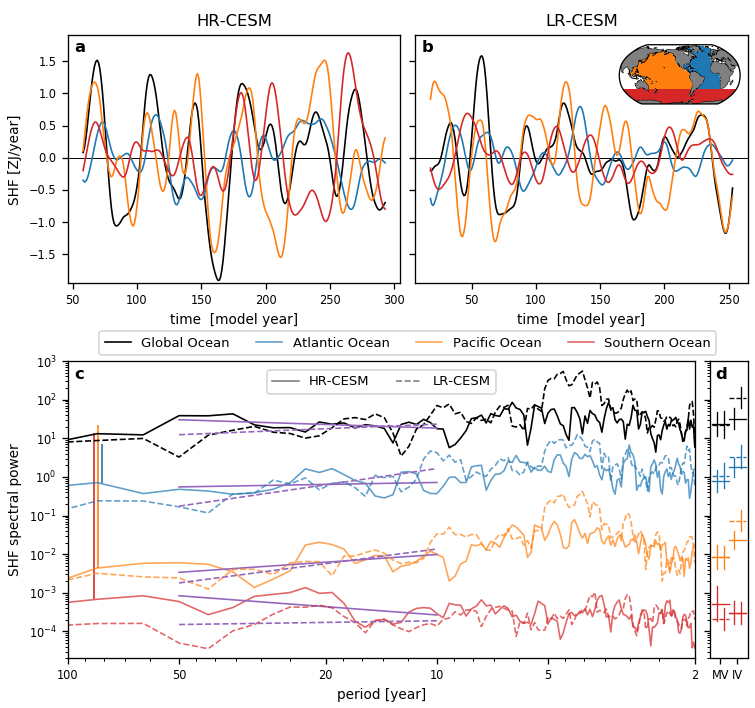

In [135]:
f = plt.figure(figsize=(6.4,6), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

ax0 = f.add_axes([.09,.6,.44,.35])
ax0.set_title('HR-CESM')
ax0.set_ylabel('SHF [ZJ/year]')
ax0.set_xlabel('time  [model year]')

ax1 = f.add_axes([.55,.6,.44,.35])
ax1.set_title('LR-CESM')
ax1.set_xlabel('time  [model year]')
ax1.set_yticklabels([])

# time series
for i, ax in enumerate([ax0, ax1]):
    ax.set_ylim((-1.95,1.9))
    ax.axhline(0, c='k', lw=.5)

    ts = [SHF_ctrl,SHF_lc1][i]
    time = [np.arange(51,301), np.arange(11,261)][i]
    ax.axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        # ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21, 13)
        ax.plot(time[7:-7], ts_[7:-7], c=c)
    ax.text(.02,.98, ['a','b'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')        

cmap = matplotlib.colors.ListedColormap(['w', 'C3', 'C1', 'w', 'C0', 'w', 'C0', 'w'])
boundaries = [-15,.5, 1.5, 2.5, 5.5, 6.5, 7.5, 9.5, 15]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
ax2 = f.add_axes([.82,.85,.16,.09], projection=ccrs.Robinson(central_longitude=250))
ax2.pcolormesh(RMASK_low.TLONG, RMASK_low.TLAT, RMASK_low,
                    cmap=cmap, norm=norm, vmin=-16, vmax=15,
                    transform=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k', facecolor='grey', linewidth=.3)

# spectra
ax = f.add_axes([.09,.07,.83,.42])
axr = f.add_axes([.94,.07,.05,.42])
ax.text(.01,.98, 'c', transform=ax.transAxes, va='top', ha='left', weight='bold')        
axr.text(.15,.98, 'd', transform=axr.transAxes, va='top', ha='left', weight='bold')        
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts_ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21
        (spec, freq, jackknife) = ATS(ts_).spectrum()
        
        offset, slope, slope_SE = calc_slope([spec*12,freq/12])
        std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power([spec*12,freq/12,jackknife])
        
        shift = [1,1/10,1/5000,1/20000][j]
        l, = ax.plot(freq, spec*shift,
                      label=f'{basin} Ocean',
                      ls=ls, c=c, alpha=[1,.7,.7,.7][j])
        l_, = ax.plot([0,0],[0,1], ls=ls, c='grey', label=['HR-CESM','LR-CESM'][i])
        if j==0:  h_.append(l_)
        if i==0:
            h.append(l)
            if j>0:  ax.arrow(1/83+(1/82-1/84)*(2-j), spec[3], 0, -(spec[3]-spec[3]*shift),\
                               length_includes_head=True, width=1e-6, head_width=0, head_length=0, color=c)

        lw=.8
        axr.plot([0,.5], 2*[shift*mu_MV], c=c, ls=ls, lw=lw)
        axr.plot([.5,1], 2*[shift*mu_IV], c=c, ls=ls, lw=lw)
        axr.plot(2*[.15+0.2*i], [shift*mu_MV*(10**sd_MV), shift*mu_MV/(10**sd_MV)], c=c, ls='-', lw=lw)
        axr.plot(2*[.65+0.2*i], [shift*mu_IV*(10**sd_IV), shift*mu_IV/(10**sd_IV)], c=c, ls='-', lw=lw)
        
        
        edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
        slope_, = ax.plot(edges, shift*10**offset*edges**slope, ls=ls, c='C4')
        
l1 = ax.legend(handles=h_, bbox_to_anchor=(0.5, 0.93), loc='center', frameon=True, ncol=2, fontsize=8)
ax.add_artist(l1)
l2 = ax.legend(handles=h, bbox_to_anchor=(45/83, 1.06), loc='center', ncol=4, fontsize=8)

ax.set_xlim(1/100,1/2)
ax.set_xlabel(r'period [year]')
ax.set_ylabel(r'SHF spectral power')
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)

axr.set_xticks([.25,.75])
axr.set_xticklabels(['MV','IV'])
axr.semilogy()
axr.set_yticklabels([])
for ax_ in [ax,axr]:  ax_.set_ylim((2e-5,1e3))

# plt.savefig(f'{path_results}/MV-paper/Fig5.eps')
plt.savefig(f'{path_results}/MV-paper/Fig5.png', dpi=600)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The Po

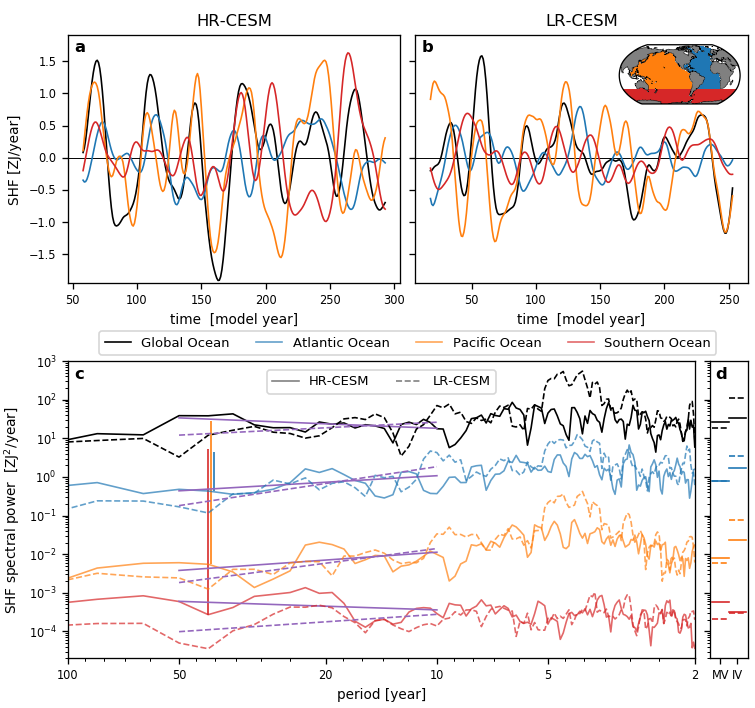

In [84]:
f = plt.figure(figsize=(6.4,6), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

ax0 = f.add_axes([.09,.6,.44,.35])
ax0.set_title('HR-CESM')
ax0.set_ylabel('SHF [ZJ/year]')
ax0.set_xlabel('time  [model year]')

ax1 = f.add_axes([.55,.6,.44,.35])
ax1.set_title('LR-CESM')
ax1.set_xlabel('time  [model year]')
ax1.set_yticklabels([])

# time series
for i, ax in enumerate([ax0, ax1]):
    ax.set_ylim((-1.95,1.9))
    ax.axhline(0, c='k', lw=.5)

    ts = [SHF_ctrl,SHF_lc1][i]
    time = [np.arange(51,301), np.arange(11,261)][i]
    ax.axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        # ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21, 13)
        ax.plot(time[7:-7], ts_[7:-7], c=c)
    ax.text(.02,.98, ['a','b'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')        

cmap = matplotlib.colors.ListedColormap(['w', 'C3', 'C1', 'w', 'C0', 'w', 'C0', 'w'])
boundaries = [-15,.5, 1.5, 2.5, 5.5, 6.5, 7.5, 9.5, 15]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
ax2 = f.add_axes([.82,.85,.16,.09], projection=ccrs.Robinson(central_longitude=250))
ax2.pcolormesh(RMASK_low.TLONG, RMASK_low.TLAT, RMASK_low,
                    cmap=cmap, norm=norm, vmin=-16, vmax=15,
                    transform=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k', facecolor='grey', linewidth=.3)

# spectra
ax = f.add_axes([.09,.07,.83,.42])
axr = f.add_axes([.94,.07,.05,.42])
ax.text(.01,.98, 'c', transform=ax.transAxes, va='top', ha='left', weight='bold')        
axr.text(.15,.98, 'd', transform=axr.transAxes, va='top', ha='left', weight='bold')        
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts_ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21
        (spec, freq, jackknife) = ATS(ts_).spectrum()
        
        offset, slope, slope_SE = calc_slope(spec)
        std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power(spec)
        
        shift= [1,1/10,1/5000,1/20000][j]
        l, = ax.plot(freq, spec*shift,
                      label=f'{basin} Ocean',
                      ls=ls, c=c, alpha=[1,.7,.7,.7][j])
        l_, = ax.plot([0,0],[0,1], ls=ls, c='grey', label=['HR-CESM','LR-CESM'][i])
        if j==0:  h_.append(l_)
        if i==0:
            h.append(l)
            if j>0:  ax.arrow(1/41+(1/40.3-1/41)*(2-j), spec[6], 0, -(spec[6]-spec[6]*shift),\
                               length_includes_head=True, width=1e-6, head_width=0, head_length=0, color=c)
        
        # quantification
        to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral((spec, freq, jackknife), monthly=False)
#         mv, = axr.plot([0,.5], 2*[mv_mean*shift], c=c, ls=ls, label=f'MV$_{{mean}}$={mv_mean:.2f}')
#         iv, = axr.plot([.5,1], 2*[iv_mean*shift], c=c, ls=ls, label=f'IV$_{{mean}}$={iv_mean:.2f}')
        
        axr.plot([0,.5], 2*[mu_MV], c='C2', ls=ls)
        axr.plot([.5,1], 2*[mu_IV], c='C3', ls=ls)
        axr.plot(2*[.25], [mu_MV*10**sd_MV, mu_MV/10**sd_MV], c='C2', ls=ls)
        axr.plot(2*[.75], [mu_IV*10**sd_IV, mu_IV/10**sd_IV], c='C3', ls=ls)
        
        
        edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
        slope_, = ax[j,i].plot(edges, 10**offset*edges**slope, ls=ls, c='C4')
#         slope, = ax.plot(edges, mv_factor*(edges)**mv_exp*shift, c='C4', ls=ls, label=f'MV$_{{exp}}$={mv_exp:.2f}')
        
l1 = ax.legend(handles=h_, bbox_to_anchor=(0.5, 0.93), loc='center', frameon=True, ncol=2, fontsize=8)
ax.add_artist(l1)
l2 = ax.legend(handles=h, bbox_to_anchor=(45/83, 1.06), loc='center', ncol=4, fontsize=8)

ax.set_xlim(1/100,1/2)
ax.set_xlabel(r'period [year]')
ax.set_ylabel(r'SHF spectral power  [ZJ$^2$/year]')
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)
# ax.set_ylim((2e-5,1e3))

axr.set_xticks([.25,.75])
axr.set_xticklabels(['MV','IV'])
axr.semilogy()
axr.set_yticklabels([])
for ax_ in [ax,axr]:  ax_.set_ylim((2e-5,1e3))

# plt.savefig(f'{path_results}/MV-paper/SHF_spectra')
plt.savefig(f'{path_results}/MV-paper/Fig5.eps')
plt.savefig(f'{path_results}/MV-paper/Fig5.png', dpi=600)

# Fig 6: OHC depth-zonal integral Hovmöller diagram + standard deviation (y)

In [22]:
# OHC data
ctrl = xr.open_dataset(f'{path_samoc}/OHC/OHC_integrals_ctrl.nc').isel(time=np.arange(50,300))
lc1  = xr.open_dataset(f'{path_samoc}/OHC/OHC_integrals_lc1.nc' ).isel(time=np.arange(10,260))

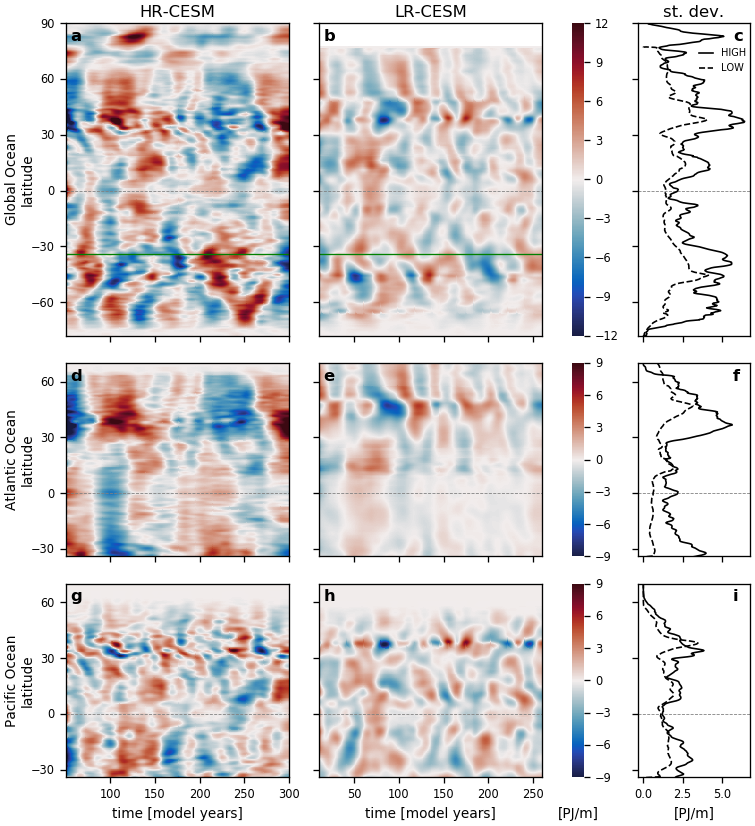

In [23]:
lc1_lat = lc1.TLAT.mean(axis=1)
extents = [(-78,90), (-34,70), (-34,70)]
height_ratios = [a[1]-a[0] for a in extents]
f, ax = plt.subplots(3, 4, figsize=(6.4,7), sharex='col',
                     gridspec_kw={"width_ratios":[1, 1, 0.05, .5], "height_ratios":height_ratios, "wspace":0.03, "hspace":0.03},
                     constrained_layout=True)
cY, cX = np.meshgrid(ctrl.t_lat, ctrl.time/365)
lY, lX = np.meshgrid(lc1.TLAT.mean(axis=1), lc1.time/365)
# vex, ims = [15, 10, 10, 5], []

vex, ims = [12, 9, 9, 6], []
for i, ocean in enumerate(['Global', 'Atlantic', 'Pacific']):
    kwargs = {'cmap':cmocean.cm.balance, 'vmin':-vex[i], 'vmax':vex[i]}
    key = f'OHC_zonal_{ocean}_Ocean'
    im = ax[i,0].pcolormesh(cX, cY, lowpass(ctrl[key]-xr_quadtrend(ctrl[key]),13)/1e15, **kwargs)
    ims.append(im)
    ax[i,1].pcolormesh(lX, lY, lowpass((lc1[key]-xr_quadtrend(lc1[key]))/100,13)/1e15, **kwargs)
    for j_, j in enumerate([0,1,3]):  
        ax[i,j].axhline(0, c='grey', lw=.5, ls='--')
        ax[i,j].set_yticks(np.arange(-60,100,30))
        ax[i,j].set_ylim(extents[i])
        ax[i,j].text([.02,.02,.85][j_],[.98,.97,.97,.95][i], string.ascii_lowercase[3*i+j_], transform=ax[i,j].transAxes, va='top', ha='left', weight='bold')        
    ax[i,1].set_yticklabels([])
#     ax[i,0].text(60, extents[i][1]-10, ocean, c='g')
    ax[i,0].yaxis.set_label_coords(-0.14,.5)
    ax[i,0].set_ylabel(f'{ocean} Ocean\nlatitude')
    
    ax[i,3].plot(lowpass(ctrl[key]-xr_quadtrend(ctrl[key]),13).std(dim='time')/1e15    , ctrl.t_lat, c='k', label='HIGH')
    ax[i,3].plot(lowpass(lc1[key] -xr_quadtrend(lc1[key] ),13).std(dim='time')/1e15/100, lc1_lat   , c='k', label='LOW' , ls='--')
    ax[i,3].set_yticklabels([])
    
    ax[i,0].get_shared_y_axes().join(ax[i,0], ax[i,1])
    ax[i,0].get_shared_y_axes().join(ax[i,0], ax[i,3])
    
    cb = f.colorbar(ims[i], cax=ax[i,2], ticks=np.arange(-12,13,3))#, ticks=np.arange(-3e16,4e16,1e16))
    cb.outline.set_visible(False)
    
    
ax[0,3].legend(fontsize=6, handlelength=1.5, bbox_to_anchor=(1.05, .88), loc='center right', frameon=False)
# ax[0,0].text(60, -75, 'Southern Ocean', c='g')
for j in range(2):
    ax[0,j].axhline(-34, c='g', lw=.8)
    ax[0,j].text(.5, 1.02, ['HR-CESM', 'LR-CESM'][j], transform=ax[0,j].transAxes, ha='center')
    ax[-1,j].set_xlabel('time [model years]')
    ax[-1,-j-1].set_xlabel('[PJ/m]')
ax[0,3].text(.5, 1.02, 'st. dev.', transform=ax[0,3].transAxes, ha='center')
    
f.align_xlabels()
# plt.savefig(f'{path_results}/MV-paper/OHC_zonal_Hovmoeller_lowpass13')
# plt.savefig(f'{path_results}/MV-paper/Fig7.tif')
# plt.savefig(f'{path_results}/MV-paper/Fig6.png')

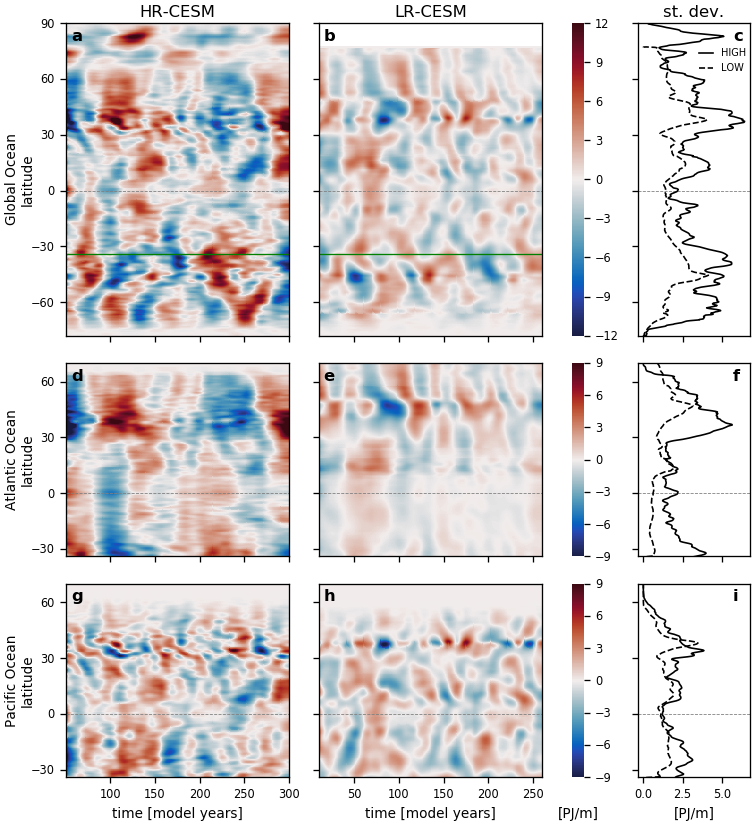

In [39]:
lc1_lat = lc1.TLAT.mean(axis=1)
extents = [(-78,90), (-34,70), (-34,70)]
height_ratios = [a[1]-a[0] for a in extents]
f, ax = plt.subplots(3, 4, figsize=(6.4,7), sharex='col',
                     gridspec_kw={"width_ratios":[1, 1, 0.05, .5], "height_ratios":height_ratios, "wspace":0.03, "hspace":0.03},
                     constrained_layout=True)
cY, cX = np.meshgrid(ctrl.t_lat, ctrl.time/365)
lY, lX = np.meshgrid(lc1.TLAT.mean(axis=1), lc1.time/365)
# vex, ims = [15, 10, 10, 5], []

vex, ims = [12, 9, 9, 6], []
for i, ocean in enumerate(['Global', 'Atlantic', 'Pacific']):
    kwargs = {'cmap':cmocean.cm.balance, 'vmin':-vex[i], 'vmax':vex[i]}
    key = f'OHC_zonal_{ocean}_Ocean'
    im = ax[i,0].pcolormesh(cX, cY, lowpass(ctrl[key]-xr_quadtrend(ctrl[key]),13)/1e15, **kwargs)
    ims.append(im)
    ax[i,1].pcolormesh(lX, lY, lowpass((lc1[key]-xr_quadtrend(lc1[key]))/100,13)/1e15, **kwargs)
    for j_, j in enumerate([0,1,3]):  
        ax[i,j].axhline(0, c='grey', lw=.5, ls='--')
        ax[i,j].set_yticks(np.arange(-60,100,30))
        ax[i,j].set_ylim(extents[i])
        ax[i,j].text([.02,.02,.85][j_],[.98,.97,.97,.95][i], string.ascii_lowercase[3*i+j_], transform=ax[i,j].transAxes, va='top', ha='left', weight='bold')        
    ax[i,1].set_yticklabels([])
#     ax[i,0].text(60, extents[i][1]-10, ocean, c='g')
    ax[i,0].yaxis.set_label_coords(-0.14,.5)
    ax[i,0].set_ylabel(f'{ocean} Ocean\nlatitude')
    
    ax[i,3].plot(lowpass(ctrl[key]-xr_quadtrend(ctrl[key]),13).std(dim='time')/1e15    , ctrl.t_lat, c='k', label='HIGH')
    ax[i,3].plot(lowpass(lc1[key] -xr_quadtrend(lc1[key] ),13).std(dim='time')/1e15/100, lc1_lat   , c='k', label='LOW' , ls='--')
    ax[i,3].set_yticklabels([])
    
    ax[i,0].get_shared_y_axes().join(ax[i,0], ax[i,1])
    ax[i,0].get_shared_y_axes().join(ax[i,0], ax[i,3])
    
    cb = f.colorbar(ims[i], cax=ax[i,2], ticks=np.arange(-12,13,3))#, ticks=np.arange(-3e16,4e16,1e16))
    cb.outline.set_visible(False)
    
    
ax[0,3].legend(fontsize=6, handlelength=1.5, bbox_to_anchor=(1.05, .88), loc='center right', frameon=False)
# ax[0,0].text(60, -75, 'Southern Ocean', c='g')
for j in range(2):
    ax[0,j].axhline(-34, c='g', lw=.8)
    ax[0,j].text(.5, 1.02, ['HR-CESM', 'LR-CESM'][j], transform=ax[0,j].transAxes, ha='center')
    ax[-1,j].set_xlabel('time [model years]')
    ax[-1,-j-1].set_xlabel('[PJ/m]')
ax[0,3].text(.5, 1.02, 'st. dev.', transform=ax[0,3].transAxes, ha='center')
    
f.align_xlabels()
# plt.savefig(f'{path_results}/MV-paper/OHC_zonal_Hovmoeller_lowpass13')
# plt.savefig(f'{path_results}/MV-paper/Fig7.tif')
plt.savefig(f'{path_results}/MV-paper/Fig6.png')

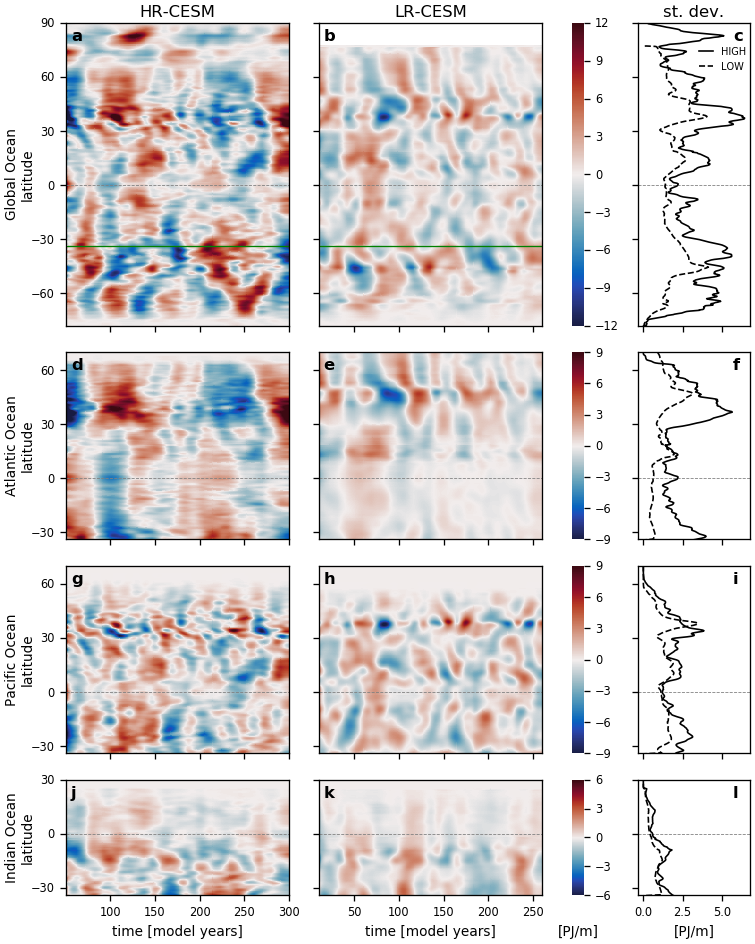

In [24]:
lc1_lat = lc1.TLAT.mean(axis=1)
extents = [(-78,90), (-34,70), (-34,70), (-34,30)]
height_ratios = [a[1]-a[0] for a in extents]
f, ax = plt.subplots(4, 4, figsize=(6.4,8), sharex='col',
                     gridspec_kw={"width_ratios":[1, 1, 0.05, .5], "height_ratios":height_ratios, "wspace":0.03, "hspace":0.03},
                     constrained_layout=True)
cY, cX = np.meshgrid(ctrl.t_lat, ctrl.time/365)
lY, lX = np.meshgrid(lc1.TLAT.mean(axis=1), lc1.time/365)
# vex, ims = [15, 10, 10, 5], []

vex, ims = [12, 9, 9, 6], []
for i, ocean in enumerate(['Global', 'Atlantic', 'Pacific', 'Indian']):
    kwargs = {'cmap':cmocean.cm.balance, 'vmin':-vex[i], 'vmax':vex[i]}
    key = f'OHC_zonal_{ocean}_Ocean'
    im = ax[i,0].pcolormesh(cX, cY, lowpass(ctrl[key]-xr_quadtrend(ctrl[key]),13)/1e15, **kwargs)
    ims.append(im)
    ax[i,1].pcolormesh(lX, lY, lowpass((lc1[key]-xr_quadtrend(lc1[key]))/100,13)/1e15, **kwargs)
    for j_, j in enumerate([0,1,3]):  
        ax[i,j].axhline(0, c='grey', lw=.5, ls='--')
        ax[i,j].set_yticks(np.arange(-60,100,30))
        ax[i,j].set_ylim(extents[i])
        ax[i,j].text([.02,.02,.85][j_],[.98,.97,.97,.95][i], string.ascii_lowercase[3*i+j_], transform=ax[i,j].transAxes, va='top', ha='left', weight='bold')        
    ax[i,1].set_yticklabels([])
#     ax[i,0].text(60, extents[i][1]-10, ocean, c='g')
    ax[i,0].yaxis.set_label_coords(-0.14,.5)
    ax[i,0].set_ylabel(f'{ocean} Ocean\nlatitude')
    
    ax[i,3].plot(lowpass(ctrl[key]-xr_quadtrend(ctrl[key]),13).std(dim='time')/1e15    , ctrl.t_lat, c='k', label='HIGH')
    ax[i,3].plot(lowpass(lc1[key] -xr_quadtrend(lc1[key] ),13).std(dim='time')/1e15/100, lc1_lat   , c='k', label='LOW' , ls='--')
    ax[i,3].set_yticklabels([])
    
    ax[i,0].get_shared_y_axes().join(ax[i,0], ax[i,1])
    ax[i,0].get_shared_y_axes().join(ax[i,0], ax[i,3])
    
    cb = f.colorbar(ims[i], cax=ax[i,2], ticks=np.arange(-12,13,3))#, ticks=np.arange(-3e16,4e16,1e16))
    cb.outline.set_visible(False)
    
    
ax[0,3].legend(fontsize=6, handlelength=1.5, bbox_to_anchor=(1.05, .88), loc='center right', frameon=False)
# ax[0,0].text(60, -75, 'Southern Ocean', c='g')
for j in range(2):
    ax[0,j].axhline(-34, c='g', lw=.8)
    ax[0,j].text(.5, 1.02, ['HR-CESM', 'LR-CESM'][j], transform=ax[0,j].transAxes, ha='center')
    ax[-1,j].set_xlabel('time [model years]')
    ax[-1,-j-1].set_xlabel('[PJ/m]')
ax[0,3].text(.5, 1.02, 'st. dev.', transform=ax[0,3].transAxes, ha='center')
    
f.align_xlabels()
# plt.savefig(f'{path_results}/MV-paper/OHC_zonal_Hovmoeller_lowpass13')
# plt.savefig(f'{path_results}/MV-paper/Fig7.tif')
plt.savefig(f'{path_results}/MV-paper/Fig6.png')

# Fig 7: OHC horizontal integral Hovmöller diagram

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


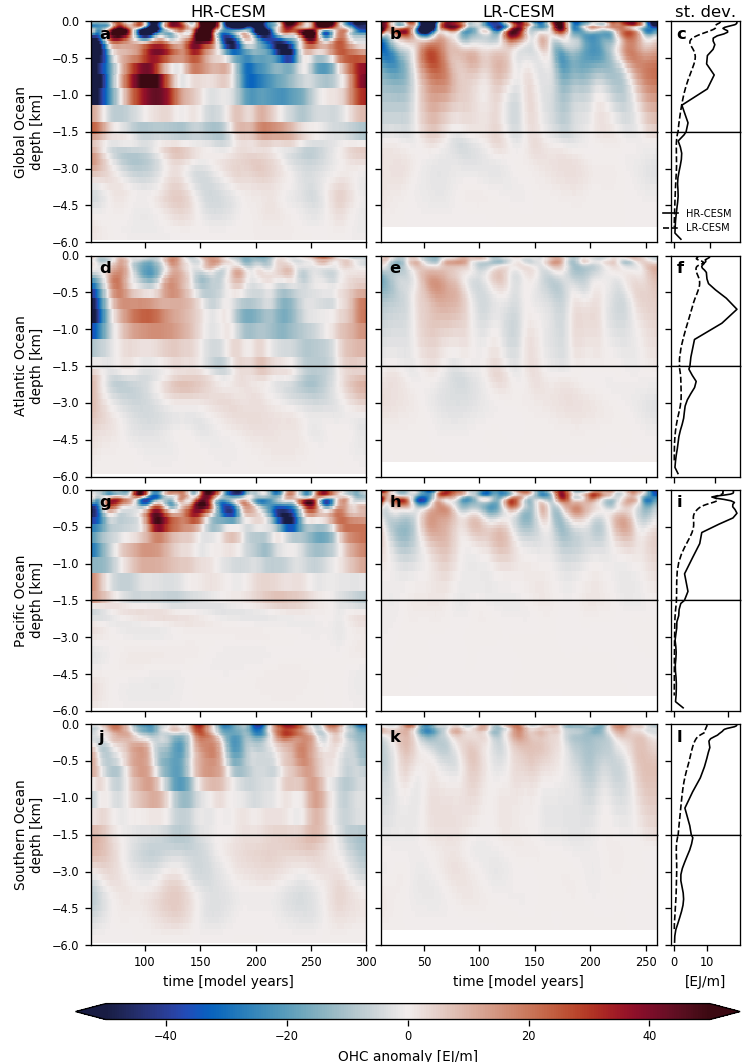

In [25]:
oceans = ['Global', 'Atlantic', 'Pacific', 'Southern']
das = [ctrl, lc1]
maxv = 50

fig = plt.figure(figsize=(6.4,9), constrained_layout=True)
gs0 = matplotlib.gridspec.GridSpec(4, 3, left=.12, right=.98, bottom=.11, top=.98, wspace=.07, hspace=.06, width_ratios=[1, 1, .25])
# if offset==True: x = (da-da.isel(time=slice(0,30)).mean(dim='time')).T/1e21
for i in range(3):
    ax_title = fig.add_subplot(gs0[0,i])
    ax_title.axis('off')
    ax_title.text(.5, 1.02, ['HR-CESM', 'LR-CESM', 'st. dev.'][i], transform=ax_title.transAxes, ha='center')

for i, ocean in enumerate(oceans):
    
    name = f'{ocean}_Ocean'    
    
    for j in range(2):
        da = das[j][f'OHC_levels_{name}']
        da = da - xr_quadtrend(da)
        
        if j==0:  # std plots
            gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[i,2], hspace=0)
            ax_t = fig.add_subplot(gs00[0])
            ax_t.set_ylim((-1500,0))
            ax_t.set_xticks([])
            ax_t.set_yticks([-1500, -1000, -500, 0])
            ax_t.text(.08,.95, string.ascii_lowercase[3*i+2], transform=ax_t.transAxes, va='top', ha='left', weight='bold')        
            
            ax_b = fig.add_subplot(gs00[1])
            ax_b.set_ylim((-6000,-1500))
            ax_b.set_yticks([-6000,-4500,-3000])
            
        x = da.T/1e18
        X, Y = np.meshgrid(da.time/365, da.coords[['depth_t', 'z_t'][j]]/[1e3, 1e5][j])
        
        gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[i,j], hspace=0)
        ax_top = fig.add_subplot(gs00[0])
        ax_top.set_ylim((-1.5,0.0))
        ax_top.set_xticks([])
        ax_top.set_yticks([-1.5, -1.0, -0.5, 0.0])
        
        ax_bot = fig.add_subplot(gs00[1])
        ax_bot.set_ylim((-6.0,-1.5))
        ax_bot.set_yticks([-6.0,-4.5,-3.0])
        
        for k, ax in enumerate([ax_t, ax_b]):
            ax.plot(lowpass(da,13).std(dim='time').values/1e18, -da.coords[['depth_t', 'z_t'][j]]/[1, 1e2][j],
                    ls=['-','--'][j], c='k', label=['HR-CESM', 'LR-CESM'][j])
                
        for k, ax in enumerate([ax_top, ax_bot]):
            im = ax.pcolormesh(X, -Y, lowpass(x.T,13).T, vmin=-maxv, vmax=maxv, cmap=cmocean.cm.balance)
        
        if j==0:
            ax_bot.yaxis.set_label_coords(-0.17,1)
            ax_bot.set_ylabel(f'{ocean} Ocean\ndepth [km]', horizontalalignment = 'center')
#             ax_bot.text(60, -5.5, f'{ocean} Ocean', horizontalalignment = 'left', c='green')
        
        if j>0:
            ax_top.set_yticklabels([])
            ax_bot.set_yticklabels([])
            ax_t.set_yticklabels([])
            ax_b.set_yticklabels([])
            
        if i==len(oceans)-1:
            ax_bot.set_xlabel('time [model years]')
            ax_b.set_xlabel('[EJ/m]')
        else:
            ax_bot.set_xticklabels([])
            ax_t.set_xticklabels([])
            ax_b.set_xticklabels([])
            
        ax_top.text(.03,.95, string.ascii_lowercase[3*i+j], transform=ax_top.transAxes, va='top', ha='left', weight='bold')        
            
    if i==0: ax_b.legend(frameon=False, handlelength=1.5, fontsize=6, loc=4)
            
cax = fig.add_axes([0.1, 0.04, 0.88, 0.015])
fig.colorbar(im, cax=cax, orientation='horizontal', label='OHC anomaly [EJ/m]', extend='both')
# plt.savefig(f'{path_results}/MV-paper/OHC_vertical_Hovmoeller_0-6km_ctrl_lc1_qd_lowpass13')
# plt.savefig(f'{path_results}/MV-paper/Fig8.tif')
plt.savefig(f'{path_results}/MV-paper/Fig7.png')


# Fig. 8: GMST / TOA spectra

In [113]:
gmst_had  = xr.open_dataarray(f'{path_prace}/GMST/GMST_dt_yrly_had.nc', decode_times=False)
gmst_had  = gmst_had.isel({'time':slice(9,158)})
gmst_ctrl = xr.open_dataset(f'{path_prace}/GMST/GMST_ctrl.nc').GMST.isel({'time':slice(50,300)})
gmst_ctrl['time'] = (gmst_ctrl.time/365).astype(dtype=int)
gmst_ctrl -= xr_quadtrend(gmst_ctrl)
gmst_lc1_ = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lc1.nc', decode_times=False)
gmst_lc1  = gmst_lc1_.rolling(time=12).mean().isel(time=slice(11,-1,12)).isel({'time':slice(10,260)})
gmst_lc1['time'] = (gmst_lc1.time/365).astype(dtype=int)
gmst_lc1 -= xr_quadtrend(gmst_lc1)

TOA_ctrl = xr.open_dataarray(f'{path_prace}/TOA/TOM_ctrl.nc', decode_times=False).isel(time=slice(50,300))
TOA_lc1  = xr.open_dataarray(f'{path_prace}/TOA/TOM_lc1.nc' , decode_times=False).isel(time=slice(10,260))

# SHF_ctrl = xr.open_dataset(f'{path_prace}/OHC/SHF_ctrl.nc', decode_times=False).isel(time=slice(50,300))
# SHF_lc1  = xr.open_dataset(f'{path_prace}/OHC/SHF_lc1.nc' , decode_times=False).isel(time=slice(10,260))
# SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False).isel(time=slice(50,300))
# SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False).isel(time=slice(10,260))

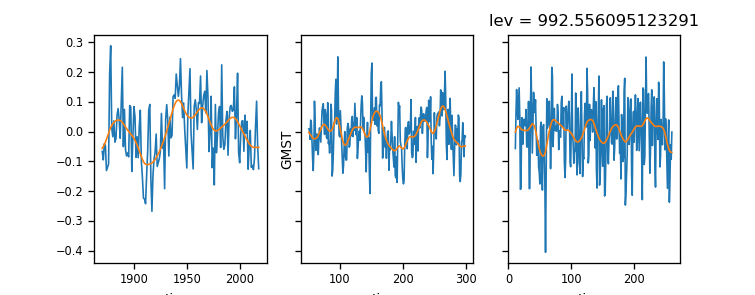

In [114]:
f, ax = plt.subplots(1,3, figsize=(6.4,2.5), sharey=True)
gmst_had.plot(ax=ax[0])
gmst_ctrl.plot(ax=ax[1])
gmst_lc1 .plot(ax=ax[2])
lowpass(gmst_had ,13).plot(ax=ax[0])
lowpass(gmst_ctrl,13).plot(ax=ax[1])
lowpass(gmst_lc1 ,13).plot(ax=ax[2])

[Text(0, 0, '50'),
 Text(0, 0, '20'),
 Text(0, 0, '10'),
 Text(0, 0, '5'),
 Text(0, 0, '2')]

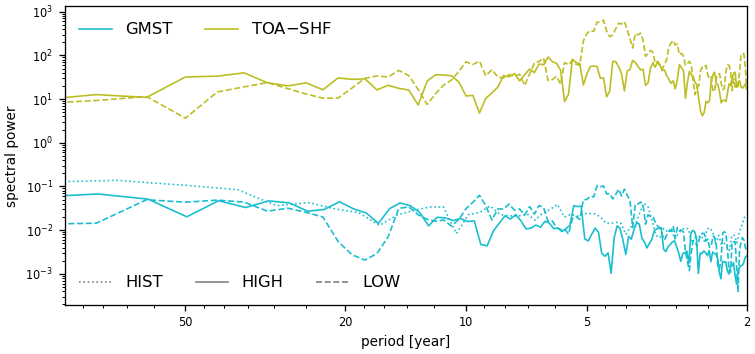

In [28]:
plt.figure(figsize=(6.4,3), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

h, h_ = [], []
for i, gmst in enumerate([gmst_had, gmst_ctrl, gmst_lc1]):
    ls = [':','-','--'][i]
    (spec, freq, jackknife) = ATS(gmst).spectrum()
#     l_, = plt.plot([0,0], [0,0], c='k', ls=ls, label=['HIST', 'HIGH', 'LOW'][i])
#     h_.append(l_)
    l, = plt.plot(freq, spec, label='GMST', c='C9', ls=ls)
    l_, = plt.plot([0,0],[0,1], ls=ls, c='grey', label=['HIST','HIGH','LOW'][i])
    h_.append(l_)
    
    if i==1: h.append(l)
l1 = plt.legend(handles=h_, bbox_to_anchor=(.3, .75), loc='center left', frameon=False)

for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    div = toa.assign_coords(time=shf.time.values)-shf
    div -= xr_quadtrend(div)
    (spec, freq, jackknife) = ATS(div).spectrum()
    l, = plt.plot(freq, spec, label=r'TOA$-$SHF', c='C8', ls=ls)
    if i==0: h.append(l)
l1 = plt.legend(handles=h_, loc='lower left', frameon=False, ncol=3)
plt.gca().add_artist(l1)
l2 = plt.legend(handles=h, loc='upper left', frameon=False, ncol=2)

plt.xlim(1/100,1/2)
plt.xlabel('period [year]')
plt.ylabel(r'spectral power')
# plt.semilogx()

xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
plt.gca().set_yscale('log', basey=10)
plt.gca().set_xscale('log', basex=10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().set_xticks([1/x for x in xticks])
plt.gca().set_xticklabels(xticks)

# plt.savefig(f'{path_results}/MV-paper/GMST_TOA-SHF_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig5.eps')

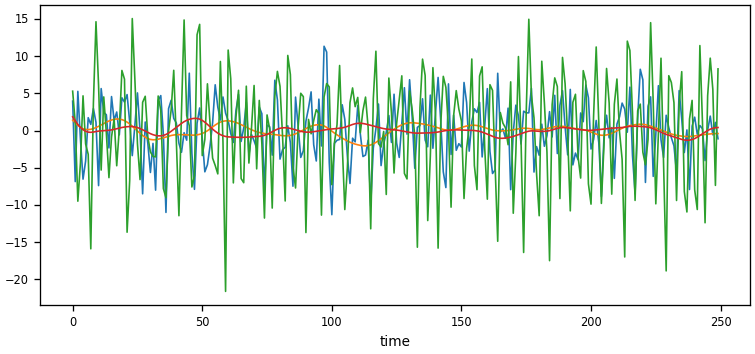

In [29]:
plt.figure(figsize=(6.4,3), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    div = toa.assign_coords(time=shf.time.values)-shf
    div -= xr_quadtrend(div)
    div.plot()
    lowpass(div,13).plot()
# l1 = plt.legend(handles=h_, loc='lower left', frameon=False, ncol=3)
# plt.gca().add_artist(l1)
# l2 = plt.legend(handles=h, loc='upper left', frameon=False, ncol=2)

# plt.xlim(1/100,1/2)
# plt.xlabel('period [year]')
# plt.ylabel(r'spectral power')
# # plt.semilogx()

# xticks = [50,20,10,5,2]
# locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
# plt.gca().set_yscale('log', basey=10)
# plt.gca().set_xscale('log', basex=10)
# plt.gca().xaxis.set_minor_locator(locmin)
# plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# plt.gca().set_xticks([1/x for x in xticks])
# plt.gca().set_xticklabels(xticks)

# plt.savefig(f'{path_results}/MV-paper/GMST_TOA-SHF_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig5.eps')

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


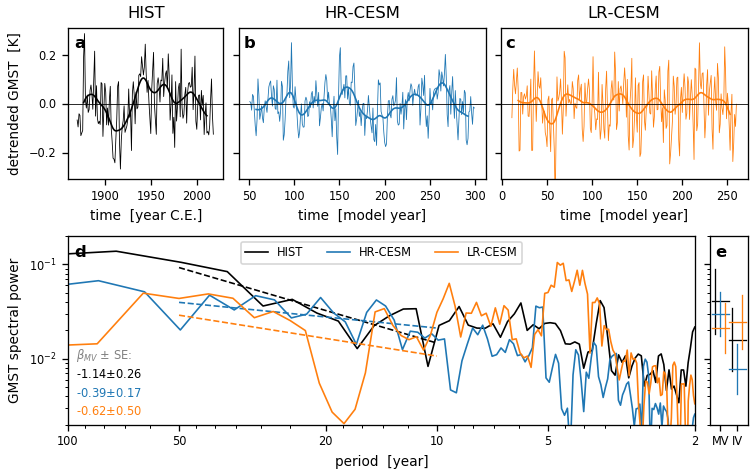

In [134]:
f = plt.figure(figsize=(6.4, 4), constrained_layout=True)

ax0 = f.add_axes([.09,.62,17/71*.86,.32])
ax0.set_title('HIST')
ax0.set_ylabel('detrended GMST  [K]')
ax0.set_xlabel('time  [year C.E.]')
ax0.set_xlim((1860,2029))
ax0.plot(gmst_had.time, gmst_had.values, lw=.5, c='k')
ax0.plot(gmst_had.time[7:-7], lowpass(gmst_had,13)[7:-7], c='k')

ax1 = f.add_axes([17/71*.86+.11,.62,27/71*.86,.32])
ax1.set_title('HR-CESM')
ax1.set_xlabel('time  [model year]')
ax1.set_yticklabels([])
ax1.plot(gmst_ctrl.time, gmst_ctrl.values, lw=.5, c='C0')
ax1.plot(gmst_ctrl.time[7:-7], lowpass(gmst_ctrl,13)[7:-7], c='C0')

ax2 = f.add_axes([44/71*.86+.13,.62,27/71*.86,.32])
ax2.set_title('LR-CESM')
ax2.set_xlabel('time  [model year]')
ax2.set_yticklabels([])
ax2.plot(gmst_lc1.time, gmst_lc1.values, lw=.5, c='C1')
ax2.plot(gmst_lc1.time[7:-7], lowpass(gmst_lc1,13)[7:-7], c='C1')

for i, ax in enumerate([ax0,ax1,ax2]):
    ax.axhline(0,c='k', lw=.5)
    ax.set_ylim((-.31,.31))
    ax.text([.04,.02,.02][i],.95, ['a','b','c'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')        


# ax = f.add_axes([.09,.1,.90,.4])

ax = f.add_axes([.09,.1,.83,.4])
axr = f.add_axes([.94,.1,.05,.4])

ax.text(.01,.95, 'd', transform=ax.transAxes, va='top', ha='left', weight='bold')        
axr.text(.15,.95, 'e', transform=axr.transAxes, va='top', ha='left', weight='bold')        
for i, gmst in enumerate([gmst_had, gmst_ctrl, gmst_lc1]):
    c = ['k', 'C0', 'C1'][i]
    ls = '-'
    (spec, freq, jackknife) = ATS(gmst).spectrum()
    offset, slope, slope_SE = calc_slope([spec*12,freq/12])
    std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power([spec*12,freq/12,jackknife])
    
    l, = ax.plot(freq, spec, label=['HIST','HR-CESM','LR-CESM'][i], c=c, ls=ls)
    
    lw=.8
    axr.plot([0,.5], 2*[mu_MV], c=c, ls=ls, lw=lw)
    axr.plot([.5,1], 2*[mu_IV], c=c, ls=ls, lw=lw)
    axr.plot(2*[.1+0.15*i], [mu_MV*(10**sd_MV), mu_MV/(10**sd_MV)], c=c, ls='-', lw=lw)
    axr.plot(2*[.6+0.15*i], [mu_IV*(10**sd_IV), mu_IV/(10**sd_IV)], c=c, ls='-', lw=lw)

    edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
    slope_, = ax.plot(edges, 10**offset*edges**slope, ls='--', c=c)
    
    if i==0:
        bMV = r'$\beta_{MV}$'
        ax.text(1/95, 10**(-2), f'{bMV} $\pm$ SE:', color='grey', fontsize=7)
    ax.text(1/95, 10**(-2.2-i*.2), f'{slope:.2f}$\pm${slope_SE:.2f}', color=c, fontsize=7)
    
ax.legend(fontsize=7, ncol=3, loc='upper center')

ax.set_xlabel('period  [year]')
ax.set_ylabel(r'GMST spectral power')
ax.set_xlim(1/100,1/2)
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)


axr.set_xticks([.25,.75])
axr.set_xticklabels(['MV','IV'])
axr.semilogy()
axr.set_yticklabels([])
for ax_ in [ax,axr]:  ax_.set_ylim((2e-3,2e-1))

plt.savefig(f'{path_results}/MV-paper/Fig8.eps')

NameError: name 'gmst_had' is not defined

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


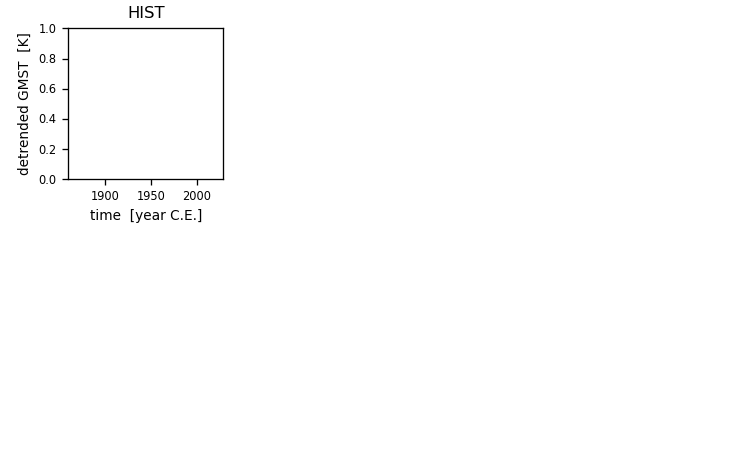

In [112]:
f = plt.figure(figsize=(6.4, 4), constrained_layout=True)

ax0 = f.add_axes([.09,.62,17/71*.86,.32])
ax0.set_title('HIST')
ax0.set_ylabel('detrended GMST  [K]')
ax0.set_xlabel('time  [year C.E.]')
ax0.set_xlim((1860,2029))
ax0.plot(gmst_had.time, gmst_had.values, lw=.5, c='k')
ax0.plot(gmst_had.time[7:-7], lowpass(gmst_had,13)[7:-7], c='k')

ax1 = f.add_axes([17/71*.86+.11,.62,27/71*.86,.32])
ax1.set_title('HR-CESM')
ax1.set_xlabel('time  [model year]')
ax1.set_yticklabels([])
ax1.plot(gmst_ctrl.time, gmst_ctrl.values, lw=.5, c='C0')
ax1.plot(gmst_ctrl.time[7:-7], lowpass(gmst_ctrl,13)[7:-7], c='C0')

ax2 = f.add_axes([44/71*.86+.13,.62,27/71*.86,.32])
ax2.set_title('LR-CESM')
ax2.set_xlabel('time  [model year]')
ax2.set_yticklabels([])
ax2.plot(gmst_lc1.time, gmst_lc1.values, lw=.5, c='C1')
ax2.plot(gmst_lc1.time[7:-7], lowpass(gmst_lc1,13)[7:-7], c='C1')

for i, ax in enumerate([ax0,ax1,ax2]):
    ax.axhline(0,c='k', lw=.5)
    ax.set_ylim((-.31,.31))
    ax.text([.04,.02,.02][i],.95, ['a','b','c'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')        


# ax = f.add_axes([.09,.1,.90,.4])

ax = f.add_axes([.09,.1,.83,.4])
axr = f.add_axes([.94,.1,.05,.4])

ax.text(.01,.95, 'd', transform=ax.transAxes, va='top', ha='left', weight='bold')        
axr.text(.15,.95, 'e', transform=axr.transAxes, va='top', ha='left', weight='bold')        
for i, gmst in enumerate([gmst_had, gmst_ctrl, gmst_lc1]):
    c = ['k', 'C0', 'C1'][i]
    ls = '-'
#     ls = [':','-','--'][i]
    (spec, freq, jackknife) = ATS(gmst).spectrum()
    l, = ax.plot(freq, spec, label=['HIST','HR-CESM','LR-CESM'][i], c=c, ls=ls)
    
    to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral((spec, freq, jackknife), monthly=False)
    mv, = axr.plot([0,.5], 2*[mv_mean], c=c, ls=ls, label=f'MV$_{{mean}}$={mv_mean:.2f}')
    iv, = axr.plot([.5,1], 2*[iv_mean], c=c, ls=ls, label=f'IV$_{{mean}}$={iv_mean:.2f}')
    
    

    edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
    slope, = ax.plot(edges, mv_factor*(edges)**mv_exp, c=c, ls='--', label=f'MV$_{{exp}}$={mv_exp:.2f}')
ax.legend(fontsize=7, ncol=3, loc='lower left')

ax.set_xlabel('period  [year]')
# ax.set_ylabel(r'GMST spectral power [K$^2$ yr]')
ax.set_ylabel(r'GMST spectral power')
ax.set_xlim(1/100,1/2)
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)


axr.set_xticks([.25,.75])
axr.set_xticklabels(['MV','IV'])
axr.semilogy()
axr.set_yticklabels([])
for ax_ in [ax,axr]:  ax_.set_ylim((2e-4,2e-1))

# plt.savefig(f'{path_results}/MV-paper/GMST_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig8.eps')

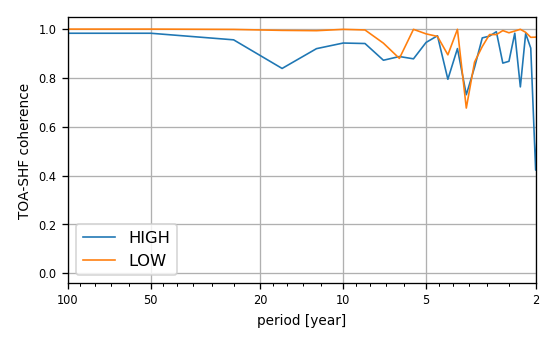

In [31]:
for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    # for n in [25,50,70,100,125]:
        # plt.cohere(toa, shf, NFFT=n,  c=f'C{i}') #label=['HIGH', 'LOW'][i],
    plt.cohere(toa, shf, NFFT=100,  c=f'C{i}', label=['HIGH', 'LOW'][i])
plt.legend()
# plt.gca().semilogx()

plt.xlim(1/100,1/2)
plt.xlabel('period [year]')
plt.ylabel(r'TOA-SHF coherence')
# plt.semilogx()

xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
# plt.gca().set_yscale('log', basey=10)
plt.gca().set_xscale('log', basex=10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().set_xticks([1/x for x in xticks])
plt.gca().set_xticklabels(xticks)
plt.tight_layout()

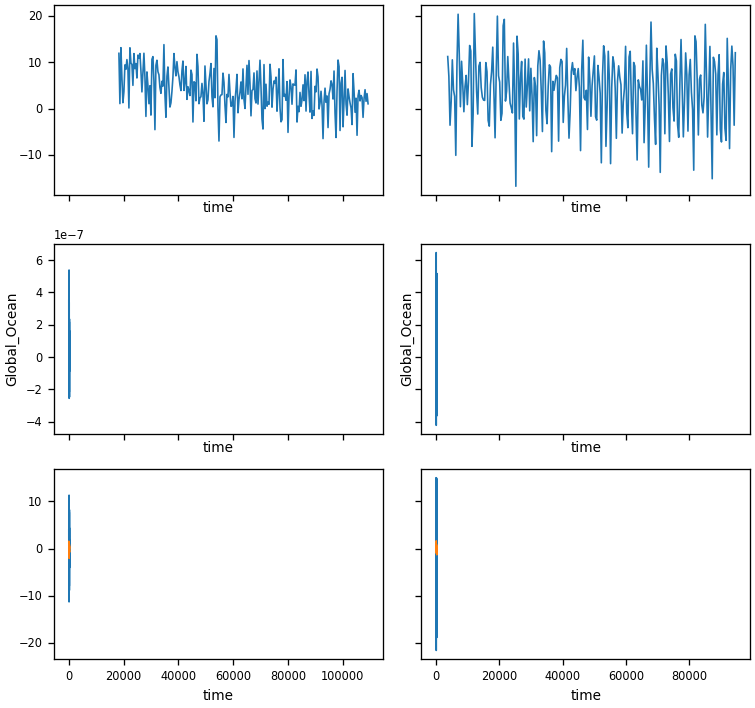

In [32]:
f, ax = plt.subplots(3,2, figsize=(6.4,6), sharey='row', sharex='col', constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    toa.plot(ax=ax[0,i])
    shf.plot(ax=ax[1,i])
    div = toa.assign_coords(time=shf.time.values)-shf
    div -= xr_quadtrend(div)
    div.plot(ax=ax[2,i])
    lowpass(div,13)[7:-7].plot(ax=ax[2,i])

In [33]:
from paths import CESM_filename
from xr_DataArrays import xr_AREA

AttributeError: 'Dataset' object has no attribute 'FSNT'

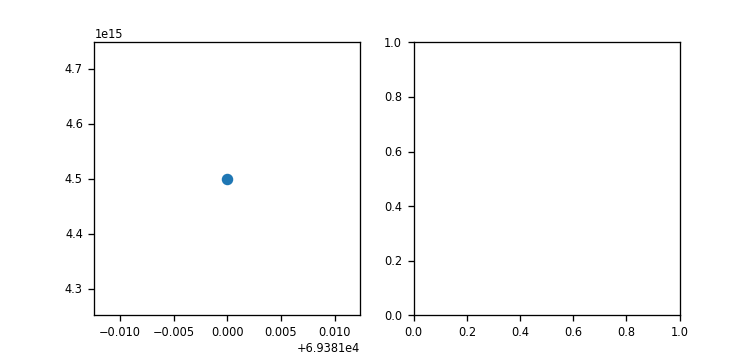

In [34]:
%%time
f, ax = plt.subplots(1,2, figsize=(6.4,3))
for i, run in enumerate(['ctrl','lc1']):
    AREA_ocn = xr_AREA(domain=['ocn','ocn_low'][i])
    AREA_atm = xr_AREA(domain=['atm','atm_f09'][i])
    for y in range(1):
        y_ = y+[190, 195][i]
        for m in notebook.tqdm(range(12)):
            do = xr.open_dataset(CESM_filename(domain='ocn', run=run, y=y_, m=m+1), decode_times=False)
            da = xr.open_dataset(CESM_filename(domain='ocn', run=run, y=y_, m=m+1), decode_times=False)
            shf = (do.SHF*AREA_ocn).sum()
            ax[0].scatter(da.time, shf.values)
            toa = ((da.FSNT-da.FLNT)*AREA_atm).sum()
            ax[1].scatter(da.time, toa.values)



# Table 2: variances for different bandpass filters

How much area/volume do the major ocean basins represent?

In [35]:
from xr_DataArrays import xr_DZ, xr_AREA
from paths import file_RMASK_ocn
from regions import regions_dict
DZT = xr_DZ('ocn')
AREA = xr_AREA('ocn')
MASK = xr.open_dataarray(file_RMASK_ocn)

In [36]:
total_area = AREA.where(MASK>0).sum(dim=['nlat','nlon'],skipna=True).values
total_volume = (DZT*AREA.where(MASK>0)).sum(dim=['z_t','nlat','nlon'],skipna=True).values
print(f'total area {total_area} volume {total_volume}')
for i in [1,2,6]:
    area = AREA.where(MASK==i).sum(dim=['nlat','nlon'],skipna=True).values
    volume = (DZT*AREA.where(MASK==i)).sum(dim=['z_t','nlat','nlon'],skipna=True).values
    print(f'{regions_dict[i]:15}: area {area/total_area*100:2.0f}%; volume {volume/total_volume*100:2.0f}%')
    

total area 359737888768820.5 volume 1.3302928999664492e+18
Southern_Ocean : area 26%; volume 27%
Pacific_Ocean  : area 38%; volume 41%
Atlantic_Ocean : area 18%; volume 18%
